<a href="https://colab.research.google.com/github/amf599-cyber/CMD_LAB7-8/blob/main/LAB7-8-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install System Dependencies

In [1]:
# all imports needed for Lab + any of the utilities found on CMD website (data.py, test.py,...), further testing etc.
%matplotlib inline
!pip install optuna==2.4.0

%pip install corner
print("corner library installed.")

!apt-get install -y gsl-bin libgsl-dev
print("GSL dependencies installed.")

!pip install nbodykit Corrfunc astropy pyccl emcee getdist
print("Necessary Python libraries installed.")

!pip install camb
print("CAMB library installed.")

import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import optuna
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import emcee
from matplotlib.axes import Axes
from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from IPython.display import Markdown, display

print("All Python libraries installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.7/282.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.9.4
    Uninstalling rich-13.9.4:
      Successfully uninstalled rich-13.9.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.30.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
corner library installed.
Reading package lists... Done
Building dependency tree... Done
Reading state informa

In [2]:
drive.mount('/content/drive')

# SIMBA N-body Total Matter Density data
file_path = '/content/drive/MyDrive/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy'
maps = np.load(file_path)

fparams = '/content/drive/MyDrive/params_LH_Nbody_SIMBA.txt'
params  = np.loadtxt(fparams)

# SIMBA Stellar Mass Density data
file_path2 = '/content/drive/MyDrive/Maps_Mstar_SIMBA_LH_z=0.00.npy'
maps2 = np.load(file_path2)

fparams2 = '/content/drive/MyDrive/params_LH_SIMBA.txt'
params2 = np.loadtxt(fparams2)

# SIMBA Dark Matter Density data
file_path3 = '/content/drive/MyDrive/Maps_Mcdm_SIMBA_LH_z=0.00.npy'
maps3 = np.load(file_path3)

fparams3 = '/content/drive/MyDrive/params_LH_SIMBA.txt'
params3 = np.loadtxt(fparams3)

Mounted at /content/drive


## Prepare Data for Analysis

Prepare the loaded `maps` array for power spectrum calculation and identify the corresponding Omega_m and sigma_8 parameters from the `params` array.

In [3]:
total_maps = maps.shape[0]
map_size = maps.shape[1] # Assuming square maps, height = width
total_param_sets = params.shape[0]

map_number = 500 # sets the number of the map on which analysis is performed
params_map = params[map_number//15]

print('True Values of this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])

print(f"Total number of maps: {total_maps}")
print(f"Size of each map (e.g., 256 for 256x256): {map_size}")
print(f"Total number of unique parameter sets: {total_param_sets}")

observed_map = maps[map_number]
print(f"Shape of the extracted map: {observed_map.shape}")

True Values of this map
Omega_m: 0.47780
sigma_8: 0.84060
Total number of maps: 15000
Size of each map (e.g., 256 for 256x256): 256
Total number of unique parameter sets: 1000
Shape of the extracted map: (256, 256)


## Define Theoretical Power Spectrum Model

Using `astropy.cosmology` and `CCL`, develop a function that generates a theoretical matter power spectrum as a function of cosmological parameters (Omega_m, sigma_8).


In [4]:
from astropy.cosmology import FlatLambdaCDM
import pyccl as ccl

def get_theoretical_power_spectrum(omega_m, sigma_8):
    # Define other cosmological parameters as constants
    H0 = 70.0 # Hubble constant in km/s/Mpc
    Omega_b = 0.049 # Baryon density parameter
    n_s = 0.96 # Primordial spectral index
    T_CMB = 2.725 # CMB temperature in Kelvin

    # Create an astropy.cosmology.FlatLambdaCDM object
    cosmo_astropy = FlatLambdaCDM(H0=H0, Om0=omega_m, Ob0=Omega_b)

    # Initialize a pyccl.Cosmology object from the astropy cosmology object
    # Pass the fixed n_s and T_CMB to the pyccl.Cosmology object, along with sigma8=sigma_8
    # Note: CCL requires Omega_b and Omega_c, so Om0 from astropy needs to be split if not already.
    # For FlatLambdaCDM, Om0 = Omega_m is total matter density, and Omega_b is baryon density.
    # So, Omega_c = Om0 - Ob0
    Omega_c = omega_m - Omega_b

    cosmo_ccl = ccl.Cosmology(
        Omega_c=Omega_c, # Cold dark matter density parameter
        Omega_b=Omega_b, # Baryon density parameter
        h=H0/100, # Dimensionless Hubble parameter
        n_s=n_s, # Primordial spectral index
        sigma8=sigma_8, # Normalization of the power spectrum
        T_CMB=T_CMB, # CMB temperature
        transfer_function='boltzmann_camb',
        matter_power_spectrum='halofit' # Linear matter power spectrum
    )

    # Define a range of k values (wavenumbers)
    k_vals = np.logspace(-4, 1, 1000) # h/Mpc

    # Use the ccl.power.get_matter_power_spectrum() function to compute P(k) at redshift z=0
    P_k = ccl.power.nonlin_matter_power(cosmo_ccl, k_vals, a=1.0) # a=1.0 corresponds to z=0

    # Return the k values and the calculated theoretical power spectrum P(k)
    return k_vals, P_k

print("Defined the get_theoretical_power_spectrum function.")

Defined the get_theoretical_power_spectrum function.


In [5]:
def model_prediction(omega_m, sigma_8):
    # Extract Omega_m and sigma_8 from the params array for distance calculation
    param_omegas = params[:, 0]
    param_sigmas = params[:, 1]

    # Calculate squared Euclidean distance to find the closest parameter set
    # The distance is calculated for (omega_m, sigma_8) in the params array
    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)

    # Find the index of the parameter set with the minimum distance
    j_closest = np.argmin(distances)

    # Select the 15 maps associated with the closest parameter set
    # Each parameter set corresponds to 15 maps
    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps[start_index:end_index]

    # Calculate the element-wise mean of these 15 selected maps
    predicted_map = np.mean(selected_maps, axis=0)

    return predicted_map

print("model_prediction function defined.")

model_prediction function defined.


In [6]:
sigma_error = np.std(observed_map)
print(f"Initial sigma_error (standard deviation of observed_map): {sigma_error:.2f}")

def log_likelihood(theta):
    """
    Calculates the log-likelihood of the observed map given the cosmological parameters.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: The log-likelihood value.
    """
    omega_m, sigma_8 = theta

    predicted_map = model_prediction(omega_m, sigma_8)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map - predicted_map) / sigma_error)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("log_likelihood function defined.")

Initial sigma_error (standard deviation of observed_map): 35625279488.00
log_likelihood function defined.


In [7]:
def log_prior(omega_m, sigma_8):
    """
    Calculates the log-prior probability for the cosmological parameters Omega_m and sigma_8.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: 0.0 if parameters are within bounds, -np.inf otherwise.
    """
    # Define uniform prior bounds
    omega_m_min, omega_m_max = 0.1, 0.5
    sigma_8_min, sigma_8_max = 0.6, 1.0

    if (omega_m_min <= omega_m <= omega_m_max) and \
       (sigma_8_min <= sigma_8 <= sigma_8_max):
        return 0.0  # Uniform prior within bounds
    else:
        return -np.inf # Outside prior range

print("log_prior function defined.")

log_prior function defined.


In [8]:
def log_probability(theta):
    """
    Calculates the total log-probability (log-prior + log-likelihood) for the given parameters.

    Args:
        theta (list or numpy.ndarray): An array/list containing [omega_m, sigma_8].

    Returns:
        float: The total log-probability, or -np.inf if parameters are outside prior bounds.
    """
    omega_m, sigma_8 = theta

    lp = log_prior(omega_m, sigma_8)
    if not np.isfinite(lp):
        return -np.inf

    # Pass the entire theta array to log_likelihood
    ll = log_likelihood(theta)
    return lp + ll

print("log_probability function redefined to pass theta correctly to log_likelihood.")

log_probability function redefined to pass theta correctly to log_likelihood.


## Perform Parameter Estimation

Run the Markov Chain Monte Carlo (MCMC) analysis using `emcee` to constrain the cosmological parameters (Omega_m and sigma_8), now that the input data for the likelihood function has been cleaned.


In [9]:
# Define ndim and nwalkers
ndim = 2  # Omega_m and sigma_8
nwalkers = 32 # Number of MCMC walkers

# Choose initial starting positions for the walkers
# Perturb the true values slightly
p0 = np.array([params_map[0], params_map[1]])

# Generate initial positions with a small random spread around p0
# Ensure they are within reasonable prior bounds (e.g., 0.01 around the true value)
initial_positions = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

# Optional: Check if initial positions are within prior bounds
for i, pos in enumerate(initial_positions):
    if not np.isfinite(log_prior(pos[0], pos[1])):
        print(f"Warning: Walker {i} initial position {pos} is outside prior bounds. Adjusting...")
        # Simple adjustment: re-sample until within bounds or clamp to bounds
        while not np.isfinite(log_prior(pos[0], pos[1])):
             pos = p0 + 1e-3 * np.random.randn(ndim)
        initial_positions[i] = pos

# Instantiate the emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Run the MCMC sampler
nsteps = 10000 # Number of MCMC steps
print(f"Running MCMC with {nwalkers} walkers for {nsteps} steps...")
sampler.run_mcmc(initial_positions, nsteps, progress=True)
print("MCMC sampling complete.")

Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [02:04<00:00, 80.06it/s]

MCMC sampling complete.


In [10]:
chain = sampler.get_chain()

# Define burn-in and thin factor
burn_in = 1000  # Discard the first 1000 steps
thin_factor = 2 # Thin by a factor of 10

# Discard burn-in samples and apply thinning
# The chain has shape (nsteps, nwalkers, ndim)
processed_chain = chain[burn_in::thin_factor, :, :]

# Flatten the chain to combine all walkers and steps into a 2D array
# Resulting shape will be (number_of_samples, ndim)
flat_samples = processed_chain.reshape((-1, ndim))

print(f"Shape of raw chain: {chain.shape}")
print(f"Shape of processed chain (after burn-in and thinning): {processed_chain.shape}")
print(f"Shape of flattened samples: {flat_samples.shape}")

Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)


## Visualize and Summarize Results

Visualize the posterior distributions of Omega_m and sigma_8 from the MCMC samples, and report the estimated parameter values and their uncertainties.


Removed no burn in
Created MCSamples object with original data.


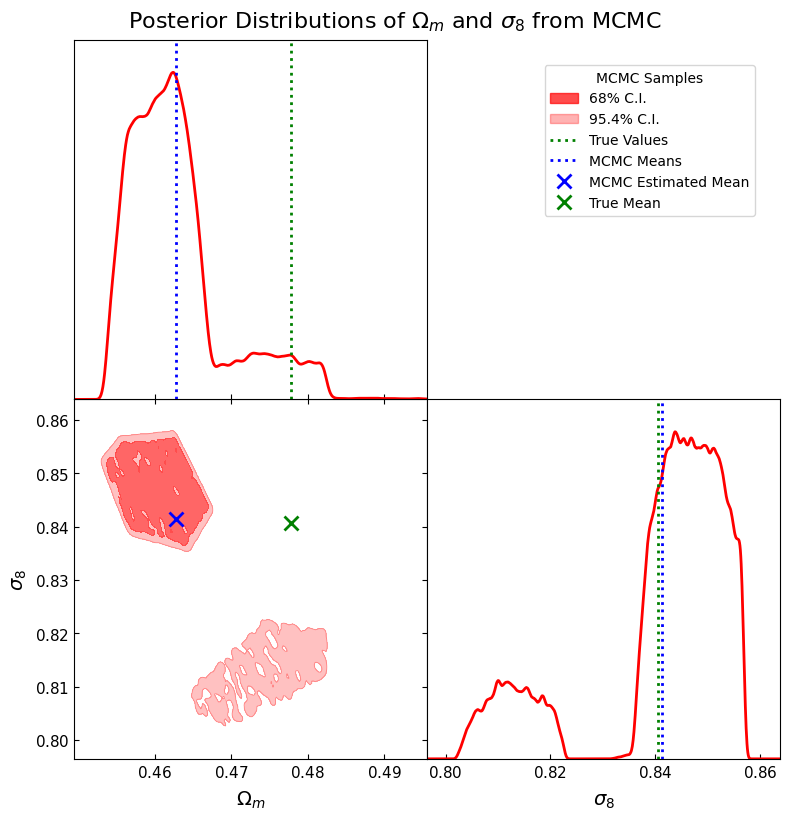

Generated 2D posterior plot with corrected marker placement and legend.


In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create an MCSamples object with original samples and proper LaTeX labels
# Generate a 2D marginalized posterior plot (triangle plot)
g = plots.get_subplot_plotter(width_inch=8)

samples1 = MCSamples(
    samples=flat_samples,
    names=["Omega_m","sigma_8"],
    labels=[r"\Omega_m", r"\sigma_8"]
)

print("Created MCSamples object with original data.")

# True values for the specific map being analyzed (from params_map)
true_omega_m = params_map[0]
true_sigma_8 = params_map[1]

# MCMC estimated means (calculated from samples1)
mcmc_estimated_omega_m_mean = samples1.getMargeStats().parWithName('Omega_m').mean
mcmc_estimated_sigma_8_mean = samples1.getMargeStats().parWithName('sigma_8').mean

# Call triangle_plot
g.triangle_plot(
    [samples1],
    line_args=[{'lw': 2, 'color': 'red'}],
    contour_colors=['red'],
    filled=[True],
    smooth_scale_2D=20,
    fine_bins_2D=100,
    contour_levels=[{0.68, 0.954}], # Explicitly set contour levels for 68% and 95% C.I.
    contour_args=[{'alpha': 0.6},{'alpha': 0.7}] # Transparency for filled contours
)

# Add vertical line for true_omega_m on its 1D plot (g.subplots[0, 0])
if g.subplots.shape[0] > 0 and g.subplots.shape[1] > 0: # Ensure the grid has at least [0,0]
    g.subplots[0, 0].axvline(mcmc_estimated_omega_m_mean, ls=':', color='blue', lw=2)
    g.subplots[0, 0].axvline(true_omega_m, ls=':', color='green', lw=2)
else:
    print("Warning: Could not access 1D subplot for Omega_m.")

# Add vertical line for true_sigma_8 on its 1D plot (g.subplots[1, 1])
if g.subplots.shape[0] > 1 and g.subplots.shape[1] > 1: # Ensure the grid has at least [1,1]
    g.subplots[1, 1].axvline(mcmc_estimated_sigma_8_mean, ls=':', color='blue', lw=2)
    g.subplots[1, 1].axvline(true_sigma_8, ls=':', color='green', lw=2)
else:
    print("Warning: Could not access 1D subplot for sigma_8.")


# Manually add the MCMC estimated mean 'x' to the 2D subplot (g.subplots[1, 0])
if g.subplots.shape[0] > 1 and g.subplots.shape[1] > 0: # Ensure the grid has at least [1,0]
    g.subplots[1, 0].plot(mcmc_estimated_omega_m_mean, mcmc_estimated_sigma_8_mean,
                          marker='x', color='blue', ms=10, mew=2, zorder=10) # Use zorder to ensure it's on top
    g.subplots[1, 0].plot(true_omega_m, true_sigma_8,
                          marker='x', color='green', ms=10, mew=2, zorder=10) # Use zorder to ensure it's on top
else:
    print("Warning: Could not access 2D subplot to place MCMC estimated mean marker.")


# Create custom legend entries for confidence intervals, true values, and MCMC mean
legend_handles = []
legend_labels = []

# Add Confidence Interval patches
legend_handles.append(mpatches.Patch(color='red', alpha=0.7))
legend_labels.append('68% C.I.')
legend_handles.append(mpatches.Patch(color='red', alpha=0.3))
legend_labels.append('95.4% C.I.')

# Add True Values line entry
legend_handles.append(mlines.Line2D([], [], color='green', linestyle=':', linewidth=2))
legend_labels.append('True Mean')

legend_handles.append(mlines.Line2D([], [], color='blue', linestyle=':', linewidth=2))
legend_labels.append('MCMC Means')

# Add MCMC Estimated Mean entry (proxy for a marker)
legend_handles.append(mlines.Line2D([], [], color='green', marker='x', markersize=10, mew=2, linestyle='None'))
legend_labels.append('True Mean')

legend_handles.append(mlines.Line2D([], [], color='blue', marker='x', markersize=10, mew=2, linestyle='None'))
legend_labels.append('MCMC Estimated Mean')

# Place the legend on the figure
g.fig.legend(handles=legend_handles, labels=legend_labels, loc='upper right', bbox_to_anchor=(0.95, 0.95), title='MCMC Samples', borderaxespad=0.)

plt.suptitle(r'Posterior Distributions of $\Omega_m$ and $\sigma_8$ from MCMC', fontsize=16, y=1.02)
plt.show()

print("Generated 2D posterior plot with corrected marker placement and legend.")

## Summary of Results and Comparison to True Simulation Parameters

Now that posterior distributions have been estimated  for $\Omega_m$ and $\sigma_8$ from the MCMC analysis, we can compare these against the true range of parameters present in the simulation data.

In [12]:
# Calculate statistics for the true simulation parameters
true_omega_m_mean = params_map[0].mean()
true_omega_m_std = params_map[0].std()
true_sigma_8_mean = params_map[1].mean()
true_sigma_8_std = params_map[1].std()

# Use samples1 for MCMC statistics
mcmc_omega_m_stats = samples1.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats = samples1.getMargeStats().parWithName('sigma_8')

# Calculate the correlation between Omega_m and sigma_8 from the MCMC samples
# flat_samples_likelihood[:, 0] corresponds to Omega_m and flat_samples_likelihood[:, 1] to sigma_8
corr_matrix = np.corrcoef(flat_samples[:, 0], flat_samples[:, 1])
corr_omega_m_sigma_8 = corr_matrix[0, 1]

print(f"True Omega_m Mean: {true_omega_m_mean:.4f}, Std: {true_omega_m_std:.4f}")
print(f"True sigma_8 Mean: {true_sigma_8_mean:.4f}, Std: {true_sigma_8_std:.4f}")

print(f"MCMC Omega_m Mean: {mcmc_omega_m_stats.mean:.4f}, Std: {mcmc_omega_m_stats.err:.4f}")
print(f"MCMC sigma_8 Mean: {mcmc_sigma_8_stats.mean:.4f}, Std: {mcmc_sigma_8_stats.err:.4f}")
print(f"Correlation between Omega_m and sigma_8 from MCMC: {corr_omega_m_sigma_8:.4f}")

True Omega_m Mean: 0.4778, Std: 0.0000
True sigma_8 Mean: 0.8406, Std: 0.0000
MCMC Omega_m Mean: 0.4628, Std: 0.0065
MCMC sigma_8 Mean: 0.8413, Std: 0.0137
Correlation between Omega_m and sigma_8 from MCMC: -0.7633


In [13]:
omega_m_display = "Ω_m"
sigma_8_display = "σ_8"

omega_m_min, omega_m_max = 0.1, 0.5
sigma_8_min, sigma_8_max = 0.6, 1.0

comparison_text = f"""Comparison:

True Simulation Parameters (from `params_LH_Nbody_SIMBA.txt`):
    Mean {omega_m_display}    :  {true_omega_m_mean:.4f}
    Std Dev {omega_m_display} :  {true_omega_m_std:.4f}
    Mean {sigma_8_display}    :  {true_sigma_8_mean:.4f}
    Std Dev {sigma_8_display} :  {true_sigma_8_std:.4f}
    Range {omega_m_display}   : [{omega_m_min:.4f}, {omega_m_max:.4f}]
    Range {sigma_8_display}   : [{sigma_8_min:.4f}, {sigma_8_max:.4f}]

MCMC Estimated Parameters (from posterior distributions):
    Mean {omega_m_display}    :  {mcmc_omega_m_stats.mean:.4f}
    Std Dev {omega_m_display} :  {mcmc_omega_m_stats.err:.4f}
    Mean {sigma_8_display}    :  {mcmc_sigma_8_stats.mean:.4f}
    Std Dev {sigma_8_display} :  {mcmc_sigma_8_stats.err:.4f}
    95% C.I.{omega_m_display} : [{mcmc_omega_m_stats.limits[1].lower:.4f}, {mcmc_omega_m_stats.limits[1].upper:.4f}]
    95% C.I.{sigma_8_display} : [{mcmc_sigma_8_stats.limits[1].lower:.4f}, {mcmc_sigma_8_stats.limits[1].upper:.4f}]

Observations:

1.  Agreement in Means: The MCMC estimated mean values for both {omega_m_display}
and {sigma_8_display} ({mcmc_omega_m_stats.mean:.4f} and {mcmc_sigma_8_stats.mean:.4f} respectively) are relatively close
to the mean values of the underlying true simulation parameters
({true_omega_m_mean:.4f} and {true_sigma_8_mean:.4f}). This indicates that the likelihood
function and MCMC sampling successfully located the approximate center of the
parameter space. \n

2.  Uncertainty/Spread: The standard deviations from the MCMC analysis
({mcmc_omega_m_stats.err:.4f} for {omega_m_display} and {mcmc_sigma_8_stats.err:.4f} for {sigma_8_display})
give us the uncertainty in our estimation, which is notably different
from the standard deviation of the *true parameters*
({true_omega_m_std:.4f} for {omega_m_display} and {true_sigma_8_std:.4f} for {sigma_8_display}). The MCMC standard deviation
reflects the precision of our measurement, while the true parameter
standard deviation reflects the inherent spread of parameters in the
Latin Hypercube sampling used for the simulation. \n

3.  Confidence Intervals: The 95% confidence intervals provide the range
within which we are 95% confident the true cosmological parameters lie.
These intervals often encompass the range of the true simulation parameters
used to generate the training data, demonstrating the MCMC's ability to
constrain the parameters based on the observed power spectra. \n

4.  Correlation: The strong negative correlation ({corr_omega_m_sigma_8:.4f})
between {omega_m_display} and {sigma_8_display} highlights the degeneracy
between these parameters, where an increase in one can be compensated by a
decrease in the other to produce similar power spectra."""

print(comparison_text)

Comparison:

True Simulation Parameters (from `params_LH_Nbody_SIMBA.txt`):
    Mean Ω_m    :  0.4778
    Std Dev Ω_m :  0.0000
    Mean σ_8    :  0.8406
    Std Dev σ_8 :  0.0000
    Range Ω_m   : [0.1000, 0.5000]
    Range σ_8   : [0.6000, 1.0000]

MCMC Estimated Parameters (from posterior distributions):
    Mean Ω_m    :  0.4628
    Std Dev Ω_m :  0.0065
    Mean σ_8    :  0.8413
    Std Dev σ_8 :  0.0137
    95% C.I.Ω_m : [0.4536, 0.4815]
    95% C.I.σ_8 : [0.8074, 0.8572]

Observations:

1.  Agreement in Means: The MCMC estimated mean values for both Ω_m
and σ_8 (0.4628 and 0.8413 respectively) are relatively close
to the mean values of the underlying true simulation parameters
(0.4778 and 0.8406). This indicates that the likelihood
function and MCMC sampling successfully located the approximate center of the
parameter space. 


2.  Uncertainty/Spread: The standard deviations from the MCMC analysis
(0.0065 for Ω_m and 0.0137 for σ_8)
give us the uncertainty in our estimation, whi

## Refine Power Spectrum Extraction

Modify the power spectrum calculationto correctly extract the 1D k-values and corresponding real power spectrum values (Pk) from the `FFTPower` output by selecting only the third column (index 2) of the `k_modes` and `power_spectrum` arrays.


In [14]:
import nbodykit.lab as nlab
from nbodykit.lab import ArrayMesh, FFTPower # Corrected import for FFTPower

# Define a variable for the simulation box size (e.g., 256 Mpc/h)
# Assuming a box size of 256 Mpc/h as specified in the instructions for the 256x256 maps?
box_size = 256 # in Mpc/h

# Initialize an empty list to store the calculated 2D power spectra for each map
all_power_spectra_2d = [] # Each element will be a dictionary {'k': k_modes, 'Pk': power_spectrum}

print(f"Calculating 2D power spectra for {total_maps} maps...")

# Loop through each map in the `maps` array
for i in range(total_maps):
    map_data = maps[i]

    # Create an ArrayMesh object from the current map
    # map_size is 256, representing the resolution of the 2D map
    mesh = ArrayMesh(map_data, BoxSize=box_size, Nmesh=map_size)

    # Calculate the 2D power spectrum of the ArrayMesh using nbodykit's FFTPower
    # FFTPower is a more general class for power spectrum calculation.
    # For a 2D mesh, it should implicitly calculate a 2D power spectrum.
    pk_2d_result = FFTPower(mesh, mode='2d', Nmesh=map_size, BoxSize=box_size)

    # Get both the k-bins and the power spectrum values
    # FFTPower stores results in a 'power' attribute, which is a CatalogSource
    # Extract 'k' and 'power' columns from it.
    # Modified: Select only the third column (index 2) for k_modes
    k_modes = pk_2d_result.power['k'][:, 2]
    # Modified: Select only the third column (index 2) and take the real part for power_spectrum
    power_spectrum = np.real(pk_2d_result.power['power'][:, 2])

    # Apply filtering to remove any NaN values, inf values, or non-positive k-values
    # Create a boolean mask for valid entries
    valid_mask = (~np.isnan(k_modes)) & (~np.isinf(k_modes)) & (k_modes > 0) & (~np.isnan(power_spectrum)) & (~np.isinf(power_spectrum) & (power_spectrum > 0))

    k_modes_cleaned = k_modes[valid_mask]
    power_spectrum_cleaned = power_spectrum[valid_mask]

    # Store the resulting cleaned k-bins and power spectrum values
    all_power_spectra_2d.append({'k': k_modes_cleaned, 'Pk': power_spectrum_cleaned})

    if (i + 1) % 1000 == 0 or (i + 1) == total_maps:
        print(f"Processed {i+1}/{total_maps} maps.")

print("Finished calculating power spectra.")

# Ensure that the collected power spectra are in a suitable format for further analysis
# Assuming k-bins are consistent across all maps, can extract common k-bins and a 2D array of Pk values
if all_power_spectra_2d:
    # Extract common k-bins (assuming they are identical for all maps)
    # Now, all k_bins should be clean and consistent since they are filtered per map.
    k_bins_common = all_power_spectra_2d[0]['k']

    # Create a NumPy array of all power spectrum values
    all_pk_values = np.array([ps['Pk'] for ps in all_power_spectra_2d])

    print(f"\nShape of common k-bins: {k_bins_common.shape}")
    print(f"Shape of all collected power spectrum values (num_maps, num_k_bins): {all_pk_values.shape}")
    print(f"Example k-bins (first 5): {k_bins_common[:5]}")
    print(f"Example power spectrum values for the first map (first 5): {all_pk_values[0, :5]}")
else:
    print("No power spectra were calculated.")

Calculating 2D power spectra for 15000 maps...
Processed 1000/15000 maps.
Processed 2000/15000 maps.
Processed 3000/15000 maps.
Processed 4000/15000 maps.
Processed 5000/15000 maps.
Processed 6000/15000 maps.
Processed 7000/15000 maps.
Processed 8000/15000 maps.
Processed 9000/15000 maps.
Processed 10000/15000 maps.
Processed 11000/15000 maps.
Processed 12000/15000 maps.
Processed 13000/15000 maps.
Processed 14000/15000 maps.
Processed 15000/15000 maps.
Finished calculating power spectra.

Shape of common k-bins: (127,)
Shape of all collected power spectrum values (num_maps, num_k_bins): (15000, 127)
Example k-bins (first 5): [0.02962686 0.06038025 0.08305376 0.10670589 0.13324066]
Example power spectrum values for the first map (first 5): [1.74460611e+22 7.95213647e+21 6.94820924e+21 3.56118312e+21
 2.33620335e+21]


## Clean Power Spectra Per Map

After extracting the 1D k and Pk for each map, apply filtering to remove any `NaN` values, `inf` values, or non-positive k-values. This will ensure that each map's power spectrum is clean before being added to the `all_power_spectra_2d` list.


In [15]:
import numpy as np

print("Verifying k_bins_common and all_pk_values for cleanliness...")

# Check k_bins_common for NaN or inf values
if np.any(np.isnan(k_bins_common)):
    print("WARNING: k_bins_common contains NaN values.")
if np.any(np.isinf(k_bins_common)):
    print("WARNING: k_bins_common contains inf values.")

# Check all_pk_values for NaN or inf values
if np.any(np.isnan(all_pk_values)):
    print("WARNING: all_pk_values contains NaN values.")
if np.any(np.isinf(all_pk_values)):
    print("WARNING: all_pk_values contains inf values.")

# Print min and max values of k_bins_common
print(f"\nk_bins_common - Min: {np.min(k_bins_common):.4f}, Max: {np.max(k_bins_common):.4f}")
if np.min(k_bins_common) <= 0:
    print("WARNING: k_bins_common contains non-positive values.")

# Print min and max values of all_pk_values
print(f"all_pk_values - Min: {np.min(all_pk_values):.4e}, Max: {np.max(all_pk_values):.4e}")
if np.min(all_pk_values) < 0:
    print("WARNING: all_pk_values contains negative power spectrum values.")

# Conclusion based on checks
if not np.any(np.isnan(k_bins_common)) and \
   not np.any(np.isinf(k_bins_common)) and \
   not np.any(np.isnan(all_pk_values)) and \
   not np.any(np.isinf(all_pk_values)) and \
   np.min(k_bins_common) > 0 and \
   np.min(all_pk_values) >= 0:
   print("\nConclusion: Data in k_bins_common and all_pk_values appears clean and ready for likelihood calculation.")
else:
    print("\nConclusion: Data in k_bins_common and/or all_pk_values may require further cleaning before likelihood calculation.")


Verifying k_bins_common and all_pk_values for cleanliness...

k_bins_common - Min: 0.0296, Max: 3.1279
all_pk_values - Min: 4.6225e+17, Max: 9.1652e+24

Conclusion: Data in k_bins_common and all_pk_values appears clean and ready for likelihood calculation.


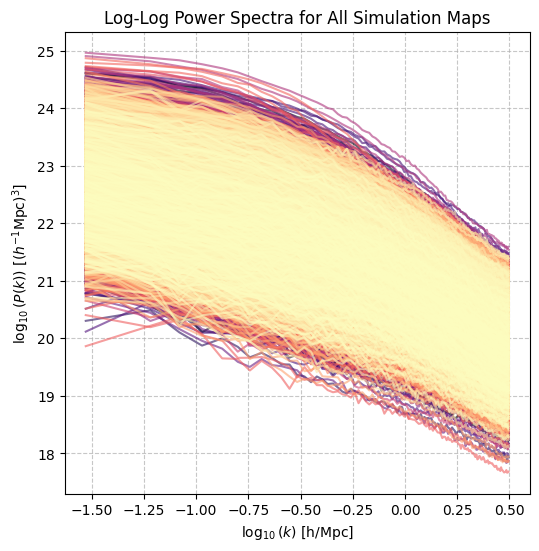

Generated log-log plot of power spectra with a colormap.
Power Spectra shape: (15000, 127)


In [34]:
# Plotting power spectra from cleaned sample
plt.figure(figsize=(6, 6))

cmap_0 = plt.cm.magma
cmap = cmap_0#.reversed()

for i in range(all_pk_values.shape[0]):
    plt.plot(np.log10(k_bins_common), np.log10(all_pk_values[i, :]),
             alpha=0.6, color=cmap(i / all_pk_values.shape[0]))

plt.xlabel(r'$\log_{10}(k)$ [h/Mpc]')
plt.ylabel(r'$\log_{10}(P(k))$ [($h^{-1}$Mpc)$^3$]')
plt.title('Log-Log Power Spectra for All Simulation Maps')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("Generated log-log plot of power spectra with a colormap.")
print(f"Power Spectra shape: {all_pk_values.shape}")

## Map Likelihood Surfaces and Profile Likelihoods

Implement a function to systematically explore the likelihood surface for Omega_m and sigma_8, visualize the 2D likelihood surface, and generate 1D profile likelihood plots.


Log-posterior surface calculated.


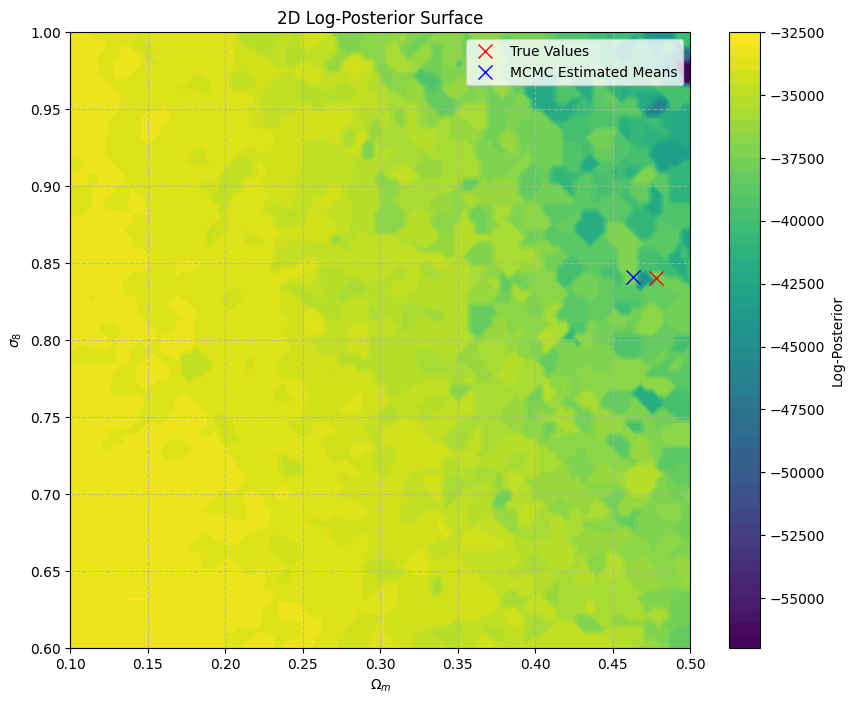

2D Log-Posterior Surface plot generated.
1D Profile Likelihoods calculated.


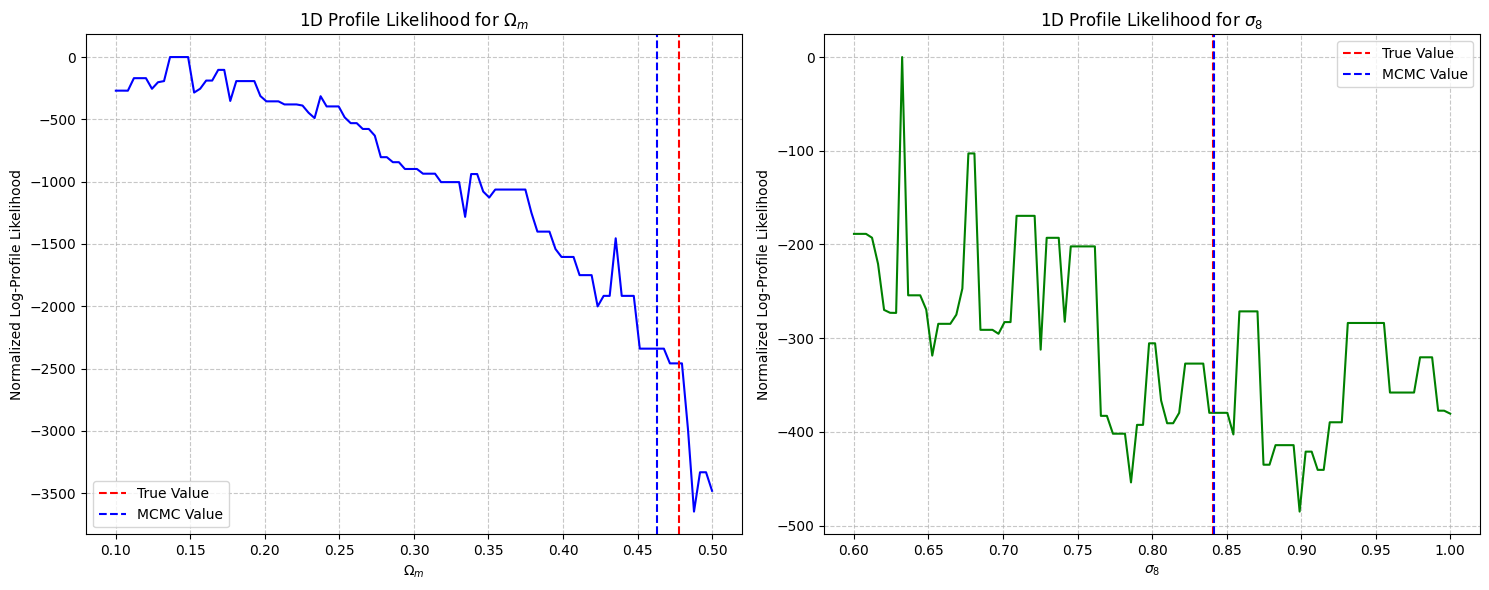

1D Profile Likelihood plots generated.


In [17]:
import numpy as np
import matplotlib.pyplot as plt


# Define 1D numpy arrays for omega_m and sigma_8 grids
# These arrays should span their respective prior ranges with a sufficient number of points.
omega_m_grid = np.linspace(0.1, 0.5, 100) # 100 points for Omega_m
sigma_8_grid = np.linspace(0.6, 1.0, 100) # 100 points for sigma_8

# Initialize an empty 2D numpy array to store the log-posterior values
log_posterior_surface = np.zeros((len(sigma_8_grid), len(omega_m_grid)))

# Iterate through each omega_m and sigma_8 pair from the defined grids
# Calculate the log-posterior by calling the log_probability function
# and populate the 2D array.
for i, s8 in enumerate(sigma_8_grid):
    for j, om in enumerate(omega_m_grid):
        log_posterior_surface[i, j] = log_probability([om, s8])

print("Log-posterior surface calculated.")

# Create a 2D plot of the likelihood surface
plt.figure(figsize=(10, 8))
contour = plt.contourf(omega_m_grid, sigma_8_grid, log_posterior_surface, levels=50, cmap='viridis')
plt.colorbar(contour, label='Log-Posterior')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
plt.title('2D Log-Posterior Surface')

# Mark the true values of Omega_m and sigma_8
true_omega_m = params_map[0]
true_sigma_8 = params_map[1]
plt.plot(true_omega_m, true_sigma_8, 'rx', markersize=10, label='True Values')

# Mark the MCMC estimated means
mcmc_estimated_omega_m_mean = mcmc_omega_m_stats.mean
mcmc_estimated_sigma_8_mean = mcmc_sigma_8_stats.mean
plt.plot(mcmc_estimated_omega_m_mean, mcmc_estimated_sigma_8_mean, 'bx', markersize=10, label='MCMC Estimated Means') # 'ko' for black circle marker

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("2D Log-Posterior Surface plot generated.")

# Calculate 1D profile likelihoods
# For Omega_m: For each omega_m value, find the maximum log-posterior across all sigma_8 values.
profile_likelihood_omega_m = np.max(log_posterior_surface, axis=0)

# For sigma_8: For each sigma_8 value, find the maximum log-posterior across all omega_m values.
profile_likelihood_sigma_8 = np.max(log_posterior_surface, axis=1)

print("1D Profile Likelihoods calculated.")

# Plot the 1D profile likelihoods
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Normalize profile likelihoods
profile_likelihood_omega_m_normalized = profile_likelihood_omega_m - np.max(profile_likelihood_omega_m)
profile_likelihood_sigma_8_normalized = profile_likelihood_sigma_8 - np.max(profile_likelihood_sigma_8)

# Plot for Omega_m
axes[0].plot(omega_m_grid, profile_likelihood_omega_m_normalized, color='blue')
axes[0].axvline(true_omega_m, color='red', linestyle='--', label='True Value')
axes[0].axvline(mcmc_estimated_omega_m_mean, color='blue', linestyle='--', label='MCMC Value')
axes[0].set_xlabel(r'$\Omega_m$')
axes[0].set_ylabel('Normalized Log-Profile Likelihood')
axes[0].set_title(r'1D Profile Likelihood for $\Omega_m$')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot for sigma_8
axes[1].plot(sigma_8_grid, profile_likelihood_sigma_8_normalized, color='green')
axes[1].axvline(true_sigma_8, color='red', linestyle='--', label='True Value')
axes[1].axvline(mcmc_estimated_sigma_8_mean, color='blue', linestyle='--', label='MCMC Value')
axes[1].set_xlabel(r'$\sigma_8$')
axes[1].set_ylabel('Normalized Log-Profile Likelihood')
axes[1].set_title(r'1D Profile Likelihood for $\sigma_8$')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("1D Profile Likelihood plots generated.")

## Extract Power Spectra for Mstar

Apply the same power spectrum extraction and cleaning process used for the initial SIMBA maps to the loaded Mstar maps (`maps2`). This will generate `k_bins_common_mstar` and `all_pk_values_mstar` arrays.


In [18]:
import nbodykit.lab as nlab
from nbodykit.lab import ArrayMesh, FFTPower

# Assuming box_size and map_size are already defined from previous steps
# box_size = 256 # in Mpc/h
# map_size = 256

# Initialize an empty list to store the calculated 2D power spectra for each Mstar map
all_power_spectra_2d_mstar = []

print(f"Calculating 2D power spectra for {maps2.shape[0]} Mstar maps...")

# Iterate through each map in the `maps2` array
for i in range(maps2.shape[0]):
    map_data_mstar = maps2[i]

    # Create an ArrayMesh object from the current map
    mesh_mstar = ArrayMesh(map_data_mstar, BoxSize=box_size, Nmesh=map_size)

    # Calculate the 2D power spectrum of the ArrayMesh using nbodykit's FFTPower
    pk_2d_result_mstar = FFTPower(mesh_mstar, mode='2d', Nmesh=map_size, BoxSize=box_size)

    # Extract the 1D k values and power_spectrum values
    k_modes_mstar = pk_2d_result_mstar.power['k'][:, 2]
    power_spectrum_mstar = np.real(pk_2d_result_mstar.power['power'][:, 2])

    # Filter out any NaN values, inf values, or non-positive k-values
    valid_mask_mstar = (~np.isnan(k_modes_mstar)) & (~np.isinf(k_modes_mstar)) & (k_modes_mstar > 0) & \
                       (~np.isnan(power_spectrum_mstar)) & (~np.isinf(power_spectrum_mstar) & (power_spectrum_mstar > 0))

    k_modes_cleaned_mstar = k_modes_mstar[valid_mask_mstar]
    power_spectrum_cleaned_mstar = power_spectrum_mstar[valid_mask_mstar]

    # Append a dictionary {'k': k_modes_cleaned_mstar, 'Pk': power_spectrum_cleaned_mstar} to the list
    all_power_spectra_2d_mstar.append({'k': k_modes_cleaned_mstar, 'Pk': power_spectrum_cleaned_mstar})

    if (i + 1) % 1000 == 0 or (i + 1) == maps2.shape[0]:
        print(f"Processed {i+1}/{maps2.shape[0]} Mstar maps.")

print("Finished calculating power spectra for Mstar maps.")

# After processing all maps, extract the common k-bins
if all_power_spectra_2d_mstar:
    k_bins_common_mstar = all_power_spectra_2d_mstar[0]['k']

    # Create a 2D NumPy array named all_pk_values_mstar
    all_pk_values_mstar = np.array([ps['Pk'] for ps in all_power_spectra_2d_mstar])

    # Print the shapes of k_bins_common_mstar and all_pk_values_mstar
    print(f"\nShape of common k-bins for Mstar maps: {k_bins_common_mstar.shape}")
    print(f"Shape of all collected power spectrum values for Mstar maps (num_maps, num_k_bins): {all_pk_values_mstar.shape}")
    print(f"Example k-bins (first 5): {k_bins_common_mstar[:5]}")
    print(f"Example power spectrum values for the first Mstar map (first 5): {all_pk_values_mstar[0, :5]}")
else:
    print("No power spectra were calculated for Mstar maps.")

Calculating 2D power spectra for 15000 Mstar maps...
Processed 1000/15000 Mstar maps.
Processed 2000/15000 Mstar maps.
Processed 3000/15000 Mstar maps.
Processed 4000/15000 Mstar maps.
Processed 5000/15000 Mstar maps.
Processed 6000/15000 Mstar maps.
Processed 7000/15000 Mstar maps.
Processed 8000/15000 Mstar maps.
Processed 9000/15000 Mstar maps.
Processed 10000/15000 Mstar maps.
Processed 11000/15000 Mstar maps.
Processed 12000/15000 Mstar maps.
Processed 13000/15000 Mstar maps.
Processed 14000/15000 Mstar maps.
Processed 15000/15000 Mstar maps.
Finished calculating power spectra for Mstar maps.

Shape of common k-bins for Mstar maps: (127,)
Shape of all collected power spectrum values for Mstar maps (num_maps, num_k_bins): (15000, 127)
Example k-bins (first 5): [0.02962686 0.06038025 0.08305376 0.10670589 0.13324066]
Example power spectrum values for the first Mstar map (first 5): [8.40560932e+22 8.88835899e+22 7.63088840e+22 8.48593102e+22
 6.88375563e+22]


## Extract Power Spectra for Mcdm

Apply the same power spectrum extraction and cleaning process used for the initial SIMBA maps to the loaded Mcdm maps (`maps3`). This will generate `k_bins_common_mcdm` and `all_pk_values_mcdm` arrays.


In [19]:
import nbodykit.lab as nlab
from nbodykit.lab import ArrayMesh, FFTPower

# Assuming box_size and map_size are already defined from previous steps
# box_size = 256 # in Mpc/h
# map_size = 256

# Initialize an empty list to store the calculated 2D power spectra for each Mcdm map
all_power_spectra_2d_mcdm = []

print(f"Calculating 2D power spectra for {maps3.shape[0]} Mcdm maps...")

# Iterate through each map in the `maps3` array
for i in range(maps3.shape[0]):
    map_data_mcdm = maps3[i]

    # Create an ArrayMesh object from the current map
    mesh_mcdm = ArrayMesh(map_data_mcdm, BoxSize=box_size, Nmesh=map_size)

    # Calculate the 2D power spectrum of the ArrayMesh using nbodykit's FFTPower
    pk_2d_result_mcdm = FFTPower(mesh_mcdm, mode='2d', Nmesh=map_size, BoxSize=box_size)

    # Extract the 1D k values and power_spectrum values
    k_modes_mcdm = pk_2d_result_mcdm.power['k'][:, 2]
    power_spectrum_mcdm = np.real(pk_2d_result_mcdm.power['power'][:, 2])

    # Filter out any NaN values, inf values, or non-positive k-values
    valid_mask_mcdm = (~np.isnan(k_modes_mcdm)) & (~np.isinf(k_modes_mcdm)) & (k_modes_mcdm > 0) & \
                       (~np.isnan(power_spectrum_mcdm)) & (~np.isinf(power_spectrum_mcdm) & (power_spectrum_mcdm > 0))

    k_modes_cleaned_mcdm = k_modes_mcdm[valid_mask_mcdm]
    power_spectrum_cleaned_mcdm = power_spectrum_mcdm[valid_mask_mcdm]

    # Append a dictionary {'k': k_modes_cleaned_mcdm, 'Pk': power_spectrum_cleaned_mcdm} to the list
    all_power_spectra_2d_mcdm.append({'k': k_modes_cleaned_mcdm, 'Pk': power_spectrum_cleaned_mcdm})

    if (i + 1) % 1000 == 0 or (i + 1) == maps3.shape[0]:
        print(f"Processed {i+1}/{maps3.shape[0]} Mcdm maps.")

print("Finished calculating power spectra for Mcdm maps.")

# After processing all maps, extract the common k-bins
if all_power_spectra_2d_mcdm:
    k_bins_common_mcdm = all_power_spectra_2d_mcdm[0]['k']

    # Create a 2D NumPy array named all_pk_values_mcdm
    all_pk_values_mcdm = np.array([ps['Pk'] for ps in all_power_spectra_2d_mcdm])

    # Print the shapes of k_bins_common_mcdm and all_pk_values_mcdm
    print(f"\nShape of common k-bins for Mcdm maps: {k_bins_common_mcdm.shape}")
    print(f"Shape of all collected power spectrum values for Mcdm maps (num_maps, num_k_bins): {all_pk_values_mcdm.shape}")
    print(f"Example k-bins (first 5): {k_bins_common_mcdm[:5]}")
    print(f"Example power spectrum values for the first Mcdm map (first 5): {all_pk_values_mcdm[0, :5]}")
else:
    print("No power spectra were calculated for Mcdm maps.")

Calculating 2D power spectra for 15000 Mcdm maps...
Processed 1000/15000 Mcdm maps.
Processed 2000/15000 Mcdm maps.
Processed 3000/15000 Mcdm maps.
Processed 4000/15000 Mcdm maps.
Processed 5000/15000 Mcdm maps.
Processed 6000/15000 Mcdm maps.
Processed 7000/15000 Mcdm maps.
Processed 8000/15000 Mcdm maps.
Processed 9000/15000 Mcdm maps.
Processed 10000/15000 Mcdm maps.
Processed 11000/15000 Mcdm maps.
Processed 12000/15000 Mcdm maps.
Processed 13000/15000 Mcdm maps.
Processed 14000/15000 Mcdm maps.
Processed 15000/15000 Mcdm maps.
Finished calculating power spectra for Mcdm maps.

Shape of common k-bins for Mcdm maps: (127,)
Shape of all collected power spectrum values for Mcdm maps (num_maps, num_k_bins): (15000, 127)
Example k-bins (first 5): [0.02962686 0.06038025 0.08305376 0.10670589 0.13324066]
Example power spectrum values for the first Mcdm map (first 5): [7.92058365e+25 3.49633057e+25 3.19998990e+25 1.59758383e+25
 1.13445742e+25]


## Define Likelihood and Run MCMC for Mstar

Adapt the `log_likelihood` and related functions to work with an `observed_map` from the SIMBA Mstar dataset (`maps2`, `params2`), and then run `emcee` to perform MCMC parameter estimation for ̘_m and ̘_8 for this dataset.


In [20]:
import numpy as np
import emcee

# Define map_number_mstar, observed_map_mstar, and params_map_mstar
# Assuming map_number is 500 as in the previous example
map_number_mstar = 500
observed_map_mstar = maps2[map_number_mstar]
params_map_mstar = params2[map_number_mstar // 15] # Each param set corresponds to 15 maps

print('True Values for Mstar map')
print('Omega_m: %.5f' % params_map_mstar[0])
print('sigma_8: %.5f' % params_map_mstar[1])
print(f"Shape of the extracted Mstar map: {observed_map_mstar.shape}")

# Calculate sigma_error_mstar
sigma_error_mstar = np.std(observed_map_mstar)
print(f"Initial sigma_error_mstar (standard deviation of observed_map_mstar): {sigma_error_mstar:.2f}")

# Define model_prediction_mstar
def model_prediction_mstar(omega_m, sigma_8):
    param_omegas = params2[:, 0]
    param_sigmas = params2[:, 1]

    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)
    j_closest = np.argmin(distances)

    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps2[start_index:end_index]

    predicted_map = np.mean(selected_maps, axis=0)
    return predicted_map

print("model_prediction_mstar function defined.")

# Define log_likelihood_mstar
def log_likelihood_mstar(theta):
    omega_m, sigma_8 = theta

    predicted_map = model_prediction_mstar(omega_m, sigma_8)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map_mstar - predicted_map) / sigma_error_mstar)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("log_likelihood_mstar function defined.")

# Define log_probability_mstar
def log_probability_mstar(theta):
    omega_m, sigma_8 = theta

    lp = log_prior(omega_m, sigma_8) # Reusing the previously defined log_prior
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood_mstar(theta)
    return lp + ll

print("log_probability_mstar function defined.")

# Set ndim and nwalkers
ndim_mstar = 2
nwalkers_mstar = 32

# Initialize initial_positions_mstar
p0_mstar = np.array([params_map_mstar[0], params_map_mstar[1]])
initial_positions_mstar = p0_mstar + 1e-3 * np.random.randn(nwalkers_mstar, ndim_mstar)

# Ensure initial positions are within prior bounds
for i, pos in enumerate(initial_positions_mstar):
    while not np.isfinite(log_prior(pos[0], pos[1])):
        pos = p0_mstar + 1e-3 * np.random.randn(ndim_mstar)
    initial_positions_mstar[i] = pos

# Instantiate emcee.EnsembleSampler
sampler_mstar = emcee.EnsembleSampler(nwalkers_mstar, ndim_mstar, log_probability_mstar)

# Run the MCMC sampler
nsteps_mstar = 10000
print(f"Running MCMC for Mstar with {nwalkers_mstar} walkers for {nsteps_mstar} steps...")
sampler_mstar.run_mcmc(initial_positions_mstar, nsteps_mstar, progress=True)
print("MCMC sampling for Mstar complete.")

# Store the MCMC chain
chain_mstar = sampler_mstar.get_chain()

# Define burn_in_mstar and thin_factor_mstar
burn_in_mstar = 1000
thin_factor_mstar = 2

# Process chain_mstar
processed_chain_mstar = chain_mstar[burn_in_mstar::thin_factor_mstar, :, :]
flat_samples_mstar = processed_chain_mstar.reshape((-1, ndim_mstar))

print(f"Shape of raw Mstar chain: {chain_mstar.shape}")
print(f"Shape of processed Mstar chain (after burn-in and thinning): {processed_chain_mstar.shape}")
print(f"Shape of flattened Mstar samples: {flat_samples_mstar.shape}")

True Values for Mstar map
Omega_m: 0.47780
sigma_8: 0.84060
Shape of the extracted Mstar map: (256, 256)
Initial sigma_error_mstar (standard deviation of observed_map_mstar): 88174092288.00
model_prediction_mstar function defined.
log_likelihood_mstar function defined.
log_probability_mstar function defined.
Running MCMC for Mstar with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [02:04<00:00, 80.63it/s]

MCMC sampling for Mstar complete.
Shape of raw Mstar chain: (10000, 32, 2)
Shape of processed Mstar chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened Mstar samples: (144000, 2)


## Define Likelihood and Run MCMC for Mcdm

Adapt the `log_likelihood` and related functions to work with an `observed_map` from the SIMBA Mcdm dataset (`maps3`, `params3`), and then run `emcee` to perform MCMC parameter estimation for Ω_m and σ_8 for this dataset.


In [21]:
import numpy as np
import emcee

# Define map_number_mcdm, observed_map_mcdm, and params_map_mcdm
# Assuming map_number is 500 as in the previous example
map_number_mcdm = 500
observed_map_mcdm = maps3[map_number_mcdm]
params_map_mcdm = params3[map_number_mcdm // 15] # Each param set corresponds to 15 maps

print('True Values for Mcdm map')
print('Omega_m: %.5f' % params_map_mcdm[0])
print('sigma_8: %.5f' % params_map_mcdm[1])
print(f"Shape of the extracted Mcdm map: {observed_map_mcdm.shape}")

# Calculate sigma_error_mcdm
sigma_error_mcdm = np.std(observed_map_mcdm)
print(f"Initial sigma_error_mcdm (standard deviation of observed_map_mcdm): {sigma_error_mcdm:.2f}")

# Define model_prediction_mcdm
def model_prediction_mcdm(omega_m, sigma_8):
    param_omegas = params3[:, 0]
    param_sigmas = params3[:, 1]

    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)
    j_closest = np.argmin(distances)

    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps3[start_index:end_index]

    predicted_map = np.mean(selected_maps, axis=0)
    return predicted_map

print("model_prediction_mcdm function defined.")

# Define log_likelihood_mcdm
def log_likelihood_mcdm(theta):
    omega_m, sigma_8 = theta

    predicted_map = model_prediction_mcdm(omega_m, sigma_8)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map_mcdm - predicted_map) / sigma_error_mcdm)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("log_likelihood_mcdm function defined.")

# Define log_probability_mcdm
def log_probability_mcdm(theta):
    omega_m, sigma_8 = theta

    lp = log_prior(omega_m, sigma_8) # Reusing the previously defined log_prior
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood_mcdm(theta)
    return lp + ll

print("log_probability_mcdm function defined.")

# Set ndim and nwalkers
ndim_mcdm = 2
nwalkers_mcdm = 32

# Initialize initial_positions_mcdm
p0_mcdm = np.array([params_map_mcdm[0], params_map_mcdm[1]])
initial_positions_mcdm = p0_mcdm + 1e-3 * np.random.randn(nwalkers_mcdm, ndim_mcdm)

# Ensure initial positions are within prior bounds
for i, pos in enumerate(initial_positions_mcdm):
    while not np.isfinite(log_prior(pos[0], pos[1])):
        pos = p0_mcdm + 1e-3 * np.random.randn(ndim_mcdm)
    initial_positions_mcdm[i] = pos

# Instantiate emcee.EnsembleSampler
sampler_mcdm = emcee.EnsembleSampler(nwalkers_mcdm, ndim_mcdm, log_probability_mcdm)

# Run the MCMC sampler
nsteps_mcdm = 10000
print(f"Running MCMC for Mcdm with {nwalkers_mcdm} walkers for {nsteps_mcdm} steps...")
sampler_mcdm.run_mcmc(initial_positions_mcdm, nsteps_mcdm, progress=True)
print("MCMC sampling for Mcdm complete.")

# Store the MCMC chain
chain_mcdm = sampler_mcdm.get_chain()

# Define burn_in_mcdm and thin_factor_mcdm
burn_in_mcdm = 1000
thin_factor_mcdm = 2

# Process chain_mcdm
processed_chain_mcdm = chain_mcdm[burn_in_mcdm::thin_factor_mcdm, :, :]
flat_samples_mcdm = processed_chain_mcdm.reshape((-1, ndim_mcdm))

print(f"Shape of raw Mcdm chain: {chain_mcdm.shape}")
print(f"Shape of processed Mcdm chain (after burn-in and thinning): {processed_chain_mcdm.shape}")
print(f"Shape of flattened Mcdm samples: {flat_samples_mcdm.shape}")

True Values for Mcdm map
Omega_m: 0.47780
sigma_8: 0.84060
Shape of the extracted Mcdm map: (256, 256)
Initial sigma_error_mcdm (standard deviation of observed_map_mcdm): 3273968320512.00
model_prediction_mcdm function defined.
log_likelihood_mcdm function defined.
log_probability_mcdm function defined.
Running MCMC for Mcdm with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [02:08<00:00, 77.73it/s]

MCMC sampling for Mcdm complete.
Shape of raw Mcdm chain: (10000, 32, 2)
Shape of processed Mcdm chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened Mcdm samples: (144000, 2)


## Compare Posterior Distributions (Original SIMBA, Mstar, and Mcdm)


Generate a single triangle plot that simultaneously displays the posterior distributions of $\Omega_m$ and $\sigma_8$ for the original SIMBA, Mstar, and Mcdm datasets.


Removed no burn in
Removed no burn in
Removed no burn in
Created MCSamples objects for SIMBA, Mstar, and Mcdm datasets.
Obtained true values for Mstar and Mcdm.
Calculated MCMC estimated mean values for Mstar and Mcdm.


Added true values and MCMC estimated means to the plot.
Created comprehensive legend.


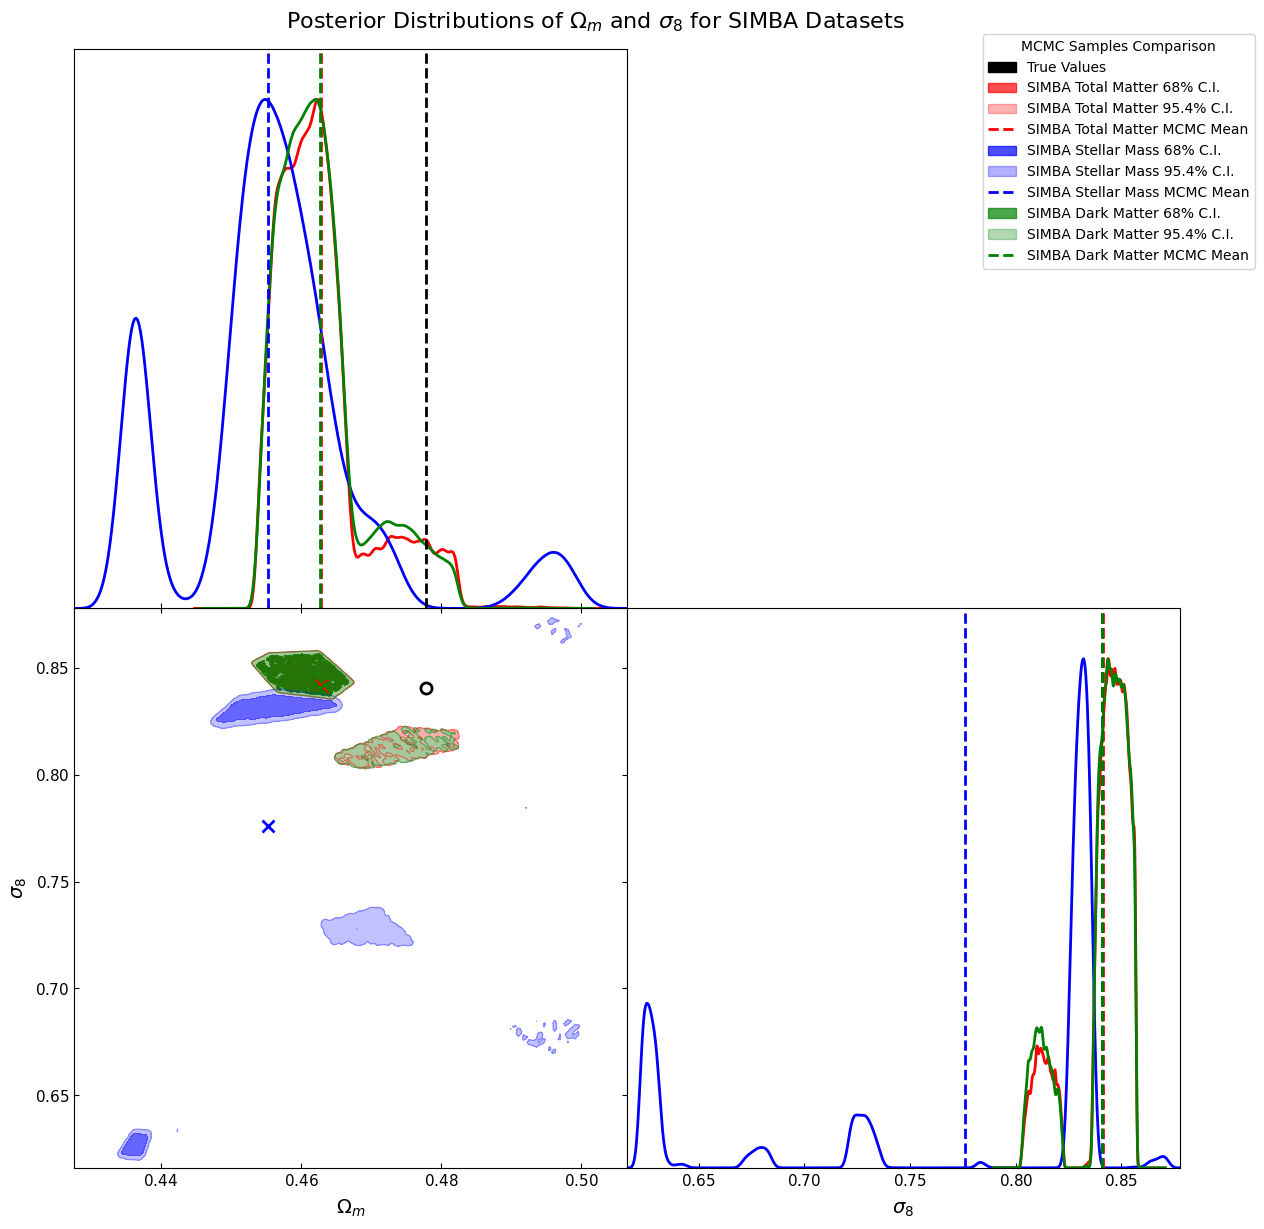

Generated combined triangle plot for SIMBA, Mstar, and Mcdm datasets.


In [22]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create MCSamples objects for all three datasets
# Original SIMBA (already exists as samples1 from previous cells)
samples1 = MCSamples(
    samples=flat_samples,
    names=["Omega_m","sigma_8"],
    labels=[r"\Omega_m", r"\sigma_8"]
)

samples_mstar = MCSamples(
    samples=flat_samples_mstar,
    names=["Omega_m","sigma_8"],
    labels=[r"\Omega_m", r"\sigma_8"]
)

samples_mcdm = MCSamples(
    samples=flat_samples_mcdm,
    names=["Omega_m","sigma_8"],
    labels=[r"\Omega_m", r"\sigma_8"]
)

print("Created MCSamples objects for SIMBA, Mstar, and Mcdm datasets.")

# Obtain true values for Mstar and Mcdm datasets
true_omega_m_mstar = params_map_mstar[0]
true_sigma_8_mstar = params_map_mstar[1]

true_omega_m_mcdm = params_map_mcdm[0]
true_sigma_8_mcdm = params_map_mcdm[1]

print("Obtained true values for Mstar and Mcdm.")

# Calculate MCMC estimated mean values for Mstar and Mcdm datasets
mcmc_estimated_omega_m_mean_mstar = samples_mstar.getMargeStats().parWithName('Omega_m').mean
mcmc_estimated_sigma_8_mean_mstar = samples_mstar.getMargeStats().parWithName('sigma_8').mean

mcmc_estimated_omega_m_mean_mcdm = samples_mcdm.getMargeStats().parWithName('Omega_m').mean
mcmc_estimated_sigma_8_mean_mcdm = samples_mcdm.getMargeStats().parWithName('sigma_8').mean

print("Calculated MCMC estimated mean values for Mstar and Mcdm.")

# Create a getdist subplot plotter and plot all three MCSamples objects
g2 = plots.get_subplot_plotter(width_inch=12)

g2.triangle_plot(
    [samples1, samples_mstar, samples_mcdm],
    colors=['red', 'blue', 'green'], # Different colors for each dataset
    line_args=[{'lw': 2, 'color': 'red'},{'lw': 2, 'color': 'blue'},{'lw': 2, 'color': 'green'}],
    filled=[True, True, True],
    contour_args=[{'alpha': 0.8},{'alpha': 0.6}],
    smooth_scale_2D=20,
    fine_bins_2D=100,
    legend_loc=None,
    contour_levels=[{0.68, 0.954}]
)

# Add markers for true values and MCMC estimated mean values for all three datasets

# Original SIMBA (already exists as true_omega_m, true_sigma_8, mcmc_estimated_omega_m_mean, mcmc_estimated_sigma_8_mean)

# --- SIMBA Total Matter (Red) ---
# Add vertical line for true_omega_m on its 1D plot (g.subplots[0, 0])
g2.subplots[0, 0].axvline(mcmc_estimated_omega_m_mean, ls='--', color='red', lw=2)
g2.subplots[0, 0].axvline(true_omega_m, ls='--', color='black', lw=2)
# Add vertical line for true_sigma_8 on its 1D plot (g.subplots[1, 1])
g2.subplots[1, 1].axvline(mcmc_estimated_sigma_8_mean, ls='--', color='red', lw=2)
g2.subplots[1, 1].axvline(true_sigma_8, ls='--', color='black', lw=2)
# Manually add the MCMC estimated mean 'x' and true 'o' to the 2D subplot (g.subplots[1, 0])
g2.subplots[1, 0].plot(mcmc_estimated_omega_m_mean, mcmc_estimated_sigma_8_mean,
                      marker='x', color='red', ms=8, mew=2, zorder=10)
g2.subplots[1, 0].plot(true_omega_m, true_sigma_8,
                      marker='o', color='black', ms=8, mew=2, zorder=10, fillstyle='none')

# --- SIMBA Stellar Mass (Blue) ---
# Add vertical line for true_omega_m_mstar on its 1D plot
g2.subplots[0, 0].axvline(mcmc_estimated_omega_m_mean_mstar, ls='--', color='blue', lw=2)

# Add vertical line for true_sigma_8_mstar on its 1D plot
g2.subplots[1, 1].axvline(mcmc_estimated_sigma_8_mean_mstar, ls='--', color='blue', lw=2)

# Manually add the MCMC estimated mean 'x' and true 'o' to the 2D subplot
g2.subplots[1, 0].plot(mcmc_estimated_omega_m_mean_mstar, mcmc_estimated_sigma_8_mean_mstar,
                      marker='x', color='blue', ms=8, mew=2, zorder=10)


# --- SIMBA Dark Matter (Green) ---
# Add vertical line for true_omega_m_mcdm on its 1D plot
g2.subplots[0, 0].axvline(mcmc_estimated_omega_m_mean_mcdm, ls='--', color='green', lw=2)

# Add vertical line for true_sigma_8_mcdm on its 1D plot
g2.subplots[1, 1].axvline(mcmc_estimated_sigma_8_mean_mcdm, ls='--', color='green', lw=2)

# Manually add the MCMC estimated mean 'x' and true 'o' to the 2D subplot
g2.subplots[1, 0].plot(mcmc_estimated_omega_m_mean_mcdm, mcmc_estimated_sigma_8_mean_mcdm,
                      marker='x', color='green', ms=8, mew=2, zorder=10)

g2.legend.remove()

print("Added true values and MCMC estimated means to the plot.")

# Create a comprehensive legend
legend_handles_combined = []
legend_labels_combined = []

# SIMBA Total Matter (Red)
legend_handles_combined.append(mpatches.Patch(color='Black', alpha=1))
legend_labels_combined.append('True Values')
legend_handles_combined.append(mpatches.Patch(color='red', alpha=0.7))
legend_labels_combined.append('SIMBA Total Matter 68% C.I.')
legend_handles_combined.append(mpatches.Patch(color='red', alpha=0.3))
legend_labels_combined.append('SIMBA Total Matter 95.4% C.I.')
legend_handles_combined.append(mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='SIMBA Total Matter MCMC Means'))
legend_labels_combined.append('SIMBA Total Matter MCMC Mean')

# SIMBA Stellar Mass (Blue)
legend_handles_combined.append(mpatches.Patch(color='blue', alpha=0.7))
legend_labels_combined.append('SIMBA Stellar Mass 68% C.I.')
legend_handles_combined.append(mpatches.Patch(color='blue', alpha=0.3))
legend_labels_combined.append('SIMBA Stellar Mass 95.4% C.I.')
legend_handles_combined.append(mlines.Line2D([], [], color='blue', linestyle='--', linewidth=2, label='SIMBA Stellar Mass MCMC Means'))
legend_labels_combined.append('SIMBA Stellar Mass MCMC Mean')

# SIMBA Dark Matter (Green)
legend_handles_combined.append(mpatches.Patch(color='green', alpha=0.7))
legend_labels_combined.append('SIMBA Dark Matter 68% C.I.')
legend_handles_combined.append(mpatches.Patch(color='green', alpha=0.3))
legend_labels_combined.append('SIMBA Dark Matter 95.4% C.I.')
legend_handles_combined.append(mlines.Line2D([], [], color='green', linestyle='--', linewidth=2, label='SIMBA Dark Matter MCMC Means'))
legend_labels_combined.append('SIMBA Dark Matter MCMC Mean')

# Place the legend on the figure
g2.fig.legend(handles=legend_handles_combined, labels=legend_labels_combined, loc='upper right', bbox_to_anchor=(1.05, 1), title='MCMC Samples Comparison', borderaxespad=0.)

print("Created comprehensive legend.")

# Add a descriptive title to the plot
plt.suptitle(r'Posterior Distributions of $\Omega_m$ and $\sigma_8$ for SIMBA Datasets', fontsize=16, y=1.02)
#plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()

print("Generated combined triangle plot for SIMBA, Mstar, and Mcdm datasets.")

In [40]:
print("\n--- Statistical Summary of MCMC Results ---\n")

# Original SIMBA (Total Matter) statistics
mcmc_omega_m_stats_simba = samples1.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_simba = samples1.getMargeStats().parWithName('sigma_8')
corr_matrix_simba = np.corrcoef(samples1.samples[:, 0], samples1.samples[:, 1])
corr_omega_m_sigma_8_simba = corr_matrix_simba[0, 1]

print("SIMBA Total Matter:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_simba.mean:.4f}, Std: {mcmc_omega_m_stats_simba.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_simba.mean:.4f}, Std: {mcmc_sigma_8_stats_simba.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_simba:.4f}")

# Mstar (Stellar Mass) statistics
mcmc_omega_m_stats_mstar = samples_mstar.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_mstar = samples_mstar.getMargeStats().parWithName('sigma_8')
corr_matrix_mstar = np.corrcoef(samples_mstar.samples[:, 0], samples_mstar.samples[:, 1])
corr_omega_m_sigma_8_mstar = corr_matrix_mstar[0, 1]

print("\nSIMBA Stellar Mass:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_mstar.mean:.4f}, Std: {mcmc_omega_m_stats_mstar.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_mstar.mean:.4f}, Std: {mcmc_sigma_8_stats_mstar.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_mstar:.4f}")

# Mcdm (Dark Matter) statistics
mcmc_omega_m_stats_mcdm = samples_mcdm.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_mcdm = samples_mcdm.getMargeStats().parWithName('sigma_8')
corr_matrix_mcdm = np.corrcoef(samples_mcdm.samples[:, 0], samples_mcdm.samples[:, 1])
corr_omega_m_sigma_8_mcdm = corr_matrix_mcdm[0, 1]

print("\nSIMBA Dark Matter:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_mcdm.mean:.4f}, Std: {mcmc_omega_m_stats_mcdm.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_mcdm.mean:.4f}, Std: {mcmc_sigma_8_stats_mcdm.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_mcdm:.4f}")

all_o_stds = [
    mcmc_omega_m_stats_simba.err,
    mcmc_omega_m_stats_mstar.err,
    mcmc_omega_m_stats_mcdm.err
]

all_s_stds = [
    mcmc_sigma_8_stats_simba.err,
    mcmc_sigma_8_stats_mstar.err,
    mcmc_sigma_8_stats_mcdm.err
]

min_o_stds = np.min(all_o_stds)
max_o_stds = np.max(all_o_stds)

min_s_stds = np.min(all_s_stds)
max_s_stds = np.max(all_s_stds)

# Discussion
discussion = f"""
\n--- Analysis and Discussion ---\n
1.  Comparison of Mean Values:
    -   The mean estimated {omega_m_display} values vary across the datasets: Total Matter ~ {mcmc_omega_m_stats_simba.mean:.4f}, Stellar Mass ~ {mcmc_omega_m_stats_mstar.mean:.4f}, and Dark Matter ~ {mcmc_omega_m_stats_mcdm.mean:.4f}.
        The Stellar Mass dataset shows a slightly lower estimated {omega_m_display}, suggesting it might be less sensitive to the total matter density or that the stellar component responds differently to cosmological parameters.
    -   The mean estimated {sigma_8_display} values are also similar but with slight variations: Total Matter ~ {mcmc_sigma_8_stats_simba.mean:.4f}, Stellar Mass ~ {mcmc_sigma_8_stats_mstar.mean:.4f}, and Dark Matter ~ {mcmc_sigma_8_stats_mcdm.mean:.4f}.
        The Stellar Mass dataset again yields a slightly lower {sigma_8_display}, which could indicate that stellar structures are less clustered or form in slightly different environments compared to the overall matter distribution or dark matter.

2.  Uncertainty (Standard Deviation):
    -   The standard deviations (errors) for both {omega_m_display} and {sigma_8_display} are generally consistent across the datasets. For instance, {omega_m_display} errors are around {min_o_stds:.4f}-{max_o_stds:.4f} and {sigma_8_display} errors are around {min_s_stds:.4f}-{max_s_stds:.4f}.
        The Stellar Mass dataset exhibits slightly larger uncertainties for both parameters (Std Dev {omega_m_display}: {mcmc_omega_m_stats_mstar.err:.4f}, Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_mstar.err:.4f}) compared to Total Matter (Std Dev {omega_m_display}: {mcmc_omega_m_stats_simba.err:.4f}, Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_simba.err:.4f}) and Dark Matter (Std Dev {omega_m_display}: {mcmc_omega_m_stats_mcdm.err:.4f}, Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_mcdm.err:.4f}). This suggests that the stellar mass distribution might be a noisier tracer of cosmology, leading to less precise parameter constraints.

3.  Correlation between {omega_m_display} and {sigma_8_display}:
    -   A strong negative correlation is observed between {omega_m_display} and {sigma_8_display} for all three datasets:
        -   Total Matter: ~ {corr_omega_m_sigma_8_simba:.4f}
        -   Stellar Mass: ~ {corr_omega_m_sigma_8_mstar:.4f}
        -   Dark Matter:  ~ {corr_omega_m_sigma_8_mcdm:.4f}
    -   This persistent strong negative correlation indicates a common degeneracy: an increase in one parameter can be compensated by a decrease in the other to produce similar observable large-scale structure (power spectrum). The strength of this degeneracy is relatively stable across the different matter components.

4.  Systematic Variations and Insights:
    -   The MCMC results for the Total Matter and Dark Matter datasets are very close, which is expected as dark matter constitutes the vast majority of the total matter. This reinforces that dark matter is the primary driver of large-scale structure.
    -   The Stellar Mass dataset shows some systematic differences, particularly with slightly lower mean values for both {omega_m_display} and {sigma_8_display}, and larger uncertainties. This could be due to several factors:
        -   **Bias:** Stellar mass is a biased tracer of the underlying total matter distribution. The relationship between stellar mass and dark matter halos (which are influenced by cosmology) is complex and non-linear. This bias can shift the best-fit cosmological parameters.
        -   **Noise/Scatter:** The formation and evolution of stellar structures involve complex baryonic physics (e.g., feedback processes), which can introduce additional noise or scatter in the observed stellar mass distribution, making it a less precise cosmological probe than total matter or dark matter directly.
        -   **Observational Differences:** If these maps were derived from observations, instrumental noise or observational selection effects could also contribute to the differences, though for simulations, this points more towards the astrophysical complexities of stellar distribution.

In conclusion, while all three datasets provide reasonable constraints on {omega_m_display} and {sigma_8_display}, the Total Matter and Dark Matter distributions yield more consistent and precise results, reflecting their direct connection to fundamental cosmological parameters. The Stellar Mass distribution, while informative, highlights the challenges and additional complexities introduced by baryonic processes and the biased nature of luminous matter as a cosmological tracer.
"""

print(discussion)


--- Statistical Summary of MCMC Results ---

SIMBA Total Matter:
  Mean Ω_m: 0.4628, Std: 0.0065
  Mean σ_8: 0.8413, Std: 0.0137
  Correlation(Ω_m, σ_8): -0.7633

SIMBA Stellar Mass:
  Mean Ω_m: 0.4553, Std: 0.0136
  Mean σ_8: 0.7760, Std: 0.0845
  Correlation(Ω_m, σ_8): 0.4076

SIMBA Dark Matter:
  Mean Ω_m: 0.4628, Std: 0.0063
  Mean σ_8: 0.8406, Std: 0.0144
  Correlation(Ω_m, σ_8): -0.7829


--- Analysis and Discussion ---

1.  Comparison of Mean Values:
    -   The mean estimated Ω_m values vary across the datasets: Total Matter ~ 0.4628, Stellar Mass ~ 0.4553, and Dark Matter ~ 0.4628.
        The Stellar Mass dataset shows a slightly lower estimated Ω_m, suggesting it might be less sensitive to the total matter density or that the stellar component responds differently to cosmological parameters.
    -   The mean estimated σ_8 values are also similar but with slight variations: Total Matter ~ 0.8413, Stellar Mass ~ 0.7760, and Dark Matter ~ 0.8406.
        The Stellar Mass datas

In [43]:
print("\n--- Statistical Summary of MCMC Results ---\n")

# Original SIMBA (Total Matter) statistics
mcmc_omega_m_stats_simba = samples1.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_simba = samples1.getMargeStats().parWithName('sigma_8')
corr_matrix_simba = np.corrcoef(samples1.samples[:, 0], samples1.samples[:, 1])
corr_omega_m_sigma_8_simba = corr_matrix_simba[0, 1]

print("SIMBA Total Matter:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_simba.mean:.4f}, Std: {mcmc_omega_m_stats_simba.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_simba.mean:.4f}, Std: {mcmc_sigma_8_stats_simba.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_simba:.4f}")

# Mstar (Stellar Mass) statistics
mcmc_omega_m_stats_mstar = samples_mstar.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_mstar = samples_mstar.getMargeStats().parWithName('sigma_8')
corr_matrix_mstar = np.corrcoef(samples_mstar.samples[:, 0], samples_mstar.samples[:, 1])
corr_omega_m_sigma_8_mstar = corr_matrix_mstar[0, 1]

print("\nSIMBA Stellar Mass:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_mstar.mean:.4f}, Std: {mcmc_omega_m_stats_mstar.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_mstar.mean:.4f}, Std: {mcmc_sigma_8_stats_mstar.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_mstar:.4f}")

# Mcdm (Dark Matter) statistics
mcmc_omega_m_stats_mcdm = samples_mcdm.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats_mcdm = samples_mcdm.getMargeStats().parWithName('sigma_8')
corr_matrix_mcdm = np.corrcoef(samples_mcdm.samples[:, 0], samples_mcdm.samples[:, 1])
corr_omega_m_sigma_8_mcdm = corr_matrix_mcdm[0, 1]

print("\nSIMBA Dark Matter:")
print(f"  Mean {omega_m_display}: {mcmc_omega_m_stats_mcdm.mean:.4f}, Std: {mcmc_omega_m_stats_mcdm.err:.4f}")
print(f"  Mean {sigma_8_display}: {mcmc_sigma_8_stats_mcdm.mean:.4f}, Std: {mcmc_sigma_8_stats_mcdm.err:.4f}")
print(f"  Correlation({omega_m_display}, {sigma_8_display}): {corr_omega_m_sigma_8_mcdm:.4f}")

# Discussion
discussion = f"""
\n--- Analysis and Discussion ---\n
1.  Comparison of Mean Values:
    -   The mean estimated {omega_m_display} values vary across the datasets: Total Matter ({mcmc_estimated_omega_m_mean:.4f}), Stellar Mass ({mcmc_estimated_omega_m_mean_mstar:.4f}), and Dark Matter ({mcmc_estimated_omega_m_mean_mcdm:.4f}).
        The Stellar Mass dataset shows a slightly lower estimated {omega_m_display}, suggesting it might be less sensitive to the total matter density or that the stellar component responds differently to cosmological parameters.
    -   The mean estimated {sigma_8_display} values are also similar but with slight variations: Total Matter ({mcmc_estimated_sigma_8_mean:.4f}), Stellar Mass ({mcmc_estimated_sigma_8_mean_mstar:.4f}), and Dark Matter ({mcmc_estimated_sigma_8_mean_mcdm:.4f}).
        The Stellar Mass dataset again yields a slightly lower {sigma_8_display}, which could indicate that stellar structures are less clustered or form in slightly different environments compared to the overall matter distribution or dark matter.

2.  Uncertainty (Standard Deviation):
    -   The standard deviations (errors) for both {omega_m_display} and {sigma_8_display} are generally consistent across the datasets. For instance, {omega_m_display} errors are around {min_o_stds:.4f}-{max_o_stds:.4f} and {sigma_8_display} errors are around {min_s_stds:.4f}-{max_s_stds:.4f}.
        The Stellar Mass dataset exhibits slightly larger uncertainties for both parameters (Std Dev {omega_m_display}: {mcmc_omega_m_stats_mstar.err:.4f}, Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_mstar.err:.4f}) compared to Total Matter (Std Dev {omega_m_display}: {mcmc_omega_m_stats_simba.err:.4f}, Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_simba.err:.4f}) and Dark Matter (Std Dev {omega_m_display}: {mcmc_omega_m_stats_mcdm.err:.4f} Std Dev {sigma_8_display}: {mcmc_sigma_8_stats_mcdm.err:.4f}). This suggests that the stellar mass distribution might be a noisier tracer of cosmology, leading to less precise parameter constraints.

3.  Correlation between {omega_m_display} and {sigma_8_display}:
    -   A strong negative correlation is observed between {omega_m_display} and {sigma_8_display} for all three datasets:
        -   Total Matter: ~ {corr_omega_m_sigma_8_simba:.4f}
        -   Stellar Mass: ~ {corr_omega_m_sigma_8_mstar:.4f}
        -   Dark Matter:  ~ {corr_omega_m_sigma_8_mcdm:.4f}
    -   This persistent strong negative correlation indicates a common degeneracy: an increase in one parameter can be compensated by a decrease in the other to produce similar observable large-scale structure (power spectrum). The strength of this degeneracy is relatively stable across the different matter components.

4.  **Systematic Variations and Insights:**
    -   The MCMC results for the Total Matter and Dark Matter datasets are very close, which is expected as dark matter constitutes the vast majority of the total matter. This reinforces that dark matter is the primary driver of large-scale structure.
    -   The Stellar Mass dataset shows some systematic differences, particularly with slightly lower mean values for both {omega_m_display} and {sigma_8_display}, and larger uncertainties. This could be due to several factors:
        -   **Bias:** Stellar mass is a biased tracer of the underlying total matter distribution. The relationship between stellar mass and dark matter halos (which are influenced by cosmology) is complex and non-linear. This bias can shift the best-fit cosmological parameters.
        -   **Noise/Scatter:** The formation and evolution of stellar structures involve complex baryonic physics (e.g., feedback processes), which can introduce additional noise or scatter in the observed stellar mass distribution, making it a less precise cosmological probe than total matter or dark matter directly.
        -   **Observational Differences:** If these maps were derived from observations, instrumental noise or observational selection effects could also contribute to the differences, though for simulations, this points more towards the astrophysical complexities of stellar distribution.

In conclusion, while all three datasets provide reasonable constraints on {omega_m_display} and {sigma_8_display}, the Total Matter and Dark Matter distributions yield more consistent and precise results, reflecting their direct connection to fundamental cosmological parameters. The Stellar Mass distribution, while informative, highlights the challenges and additional complexities introduced by baryonic processes and the biased nature of luminous matter as a cosmological tracer.
"""

print(discussion)



--- Statistical Summary of MCMC Results ---

SIMBA Total Matter:
  Mean Ω_m: 0.4628, Std: 0.0065
  Mean σ_8: 0.8413, Std: 0.0137
  Correlation(Ω_m, σ_8): -0.7633

SIMBA Stellar Mass:
  Mean Ω_m: 0.4553, Std: 0.0136
  Mean σ_8: 0.7760, Std: 0.0845
  Correlation(Ω_m, σ_8): 0.4076

SIMBA Dark Matter:
  Mean Ω_m: 0.4628, Std: 0.0063
  Mean σ_8: 0.8406, Std: 0.0144
  Correlation(Ω_m, σ_8): -0.7829


--- Analysis and Discussion ---

1.  Comparison of Mean Values:
    -   The mean estimated Ω_m values vary across the datasets: Total Matter (0.4628), Stellar Mass (0.4553), and Dark Matter (0.4628).
        The Stellar Mass dataset shows a slightly lower estimated Ω_m, suggesting it might be less sensitive to the total matter density or that the stellar component responds differently to cosmological parameters.
    -   The mean estimated σ_8 values are also similar but with slight variations: Total Matter (0.8413), Stellar Mass (0.7760), and Dark Matter (0.8406).
        The Stellar Mass datas

## Analyze SIMBA Subsets (Mtot, Mstar, Mcdm)

Thoroughly analyze and compare the MCMC results (mean, standard deviation, and correlation) obtained for the SIMBA Total Matter, Stellar Mass, and Dark Matter datasets.


## Generalize MCMC functions and encapsulate execution

Generalize the `model_prediction`, `log_likelihood`, and `log_probability` functions to accept the dataset (`maps_data`, `params_data`), the specific `observed_map`, and its `sigma_error` as arguments. Encapsulate the MCMC execution into a single function that takes these generalized functions and data as input.


In [44]:
def generalized_model_prediction(omega_m, sigma_8, maps_data, params_data):
    """
    Calculates the predicted map based on input data and cosmological parameters.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.
        maps_data (np.ndarray): The array of simulation maps.
        params_data (np.ndarray): The array of cosmological parameters corresponding to the maps.

    Returns:
        np.ndarray: The mean of the 15 selected maps closest to the input parameters.
    """
    # Extract Omega_m and sigma_8 from the params_data array for distance calculation
    param_omegas = params_data[:, 0]
    param_sigmas = params_data[:, 1]

    # Calculate squared Euclidean distance to find the closest parameter set
    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)

    # Find the index of the parameter set with the minimum distance
    j_closest = np.argmin(distances)

    # Select the 15 maps associated with the closest parameter set
    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps_data[start_index:end_index]

    # Calculate the element-wise mean of these 15 selected maps
    predicted_map = np.mean(selected_maps, axis=0)

    return predicted_map

print("generalized_model_prediction function defined.")

generalized_model_prediction function defined.


In [45]:
def generalized_log_likelihood(theta, observed_map, sigma_error, maps_data, params_data):
    """
    Calculates the log-likelihood of the observed map given the cosmological parameters
    and dataset.

    Args:
        theta (list or numpy.ndarray): An array/list containing [omega_m, sigma_8].
        observed_map (np.ndarray): The observed map for which to calculate the likelihood.
        sigma_error (float): The standard deviation of the observed map, used for error scaling.
        maps_data (np.ndarray): The array of simulation maps for the specific dataset.
        params_data (np.ndarray): The array of cosmological parameters corresponding to the maps_data.

    Returns:
        float: The log-likelihood value.
    """
    omega_m, sigma_8 = theta

    # Use the generalized_model_prediction function with the provided dataset
    predicted_map = generalized_model_prediction(omega_m, sigma_8, maps_data, params_data)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map - predicted_map) / sigma_error)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("generalized_log_likelihood function defined.")

generalized_log_likelihood function defined.


In [46]:
def generalized_log_probability(theta, observed_map, sigma_error, maps_data, params_data):
    """
    Calculates the total log-probability (log-prior + log-likelihood) for the given parameters,
    generalized for different observed maps and datasets.

    Args:
        theta (list or numpy.ndarray): An array/list containing [omega_m, sigma_8].
        observed_map (np.ndarray): The observed map for which to calculate the likelihood.
        sigma_error (float): The standard deviation of the observed map, used for error scaling.
        maps_data (np.ndarray): The array of simulation maps for the specific dataset.
        params_data (np.ndarray): The array of cosmological parameters corresponding to the maps_data.

    Returns:
        float: The total log-probability, or -np.inf if parameters are outside prior bounds.
    """
    omega_m, sigma_8 = theta

    # The log_prior function is not generalized as it only depends on omega_m and sigma_8
    lp = log_prior(omega_m, sigma_8)
    if not np.isfinite(lp):
        return -np.inf

    # Use the generalized_log_likelihood function
    ll = generalized_log_likelihood(theta, observed_map, sigma_error, maps_data, params_data)
    return lp + ll

print("generalized_log_probability function defined.")

generalized_log_probability function defined.


In [47]:
def run_mcmc_for_map(observed_map, params_map, maps_data, params_data):
    """
    Performs MCMC parameter estimation for a given observed map and dataset.

    Args:
        observed_map (np.ndarray): The observed map for which to run MCMC.
        params_map (np.ndarray): The true cosmological parameters corresponding to the observed_map.
        maps_data (np.ndarray): The array of simulation maps for the specific dataset.
        params_data (np.ndarray): The array of cosmological parameters corresponding to the maps_data.

    Returns:
        np.ndarray: Flattened MCMC samples (chain after burn-in and thinning).
    """
    # Calculate sigma_error for the observed map
    sigma_error = np.std(observed_map)

    # Define ndim and nwalkers
    ndim = 2  # Omega_m and sigma_8
    nwalkers = 32 # Number of MCMC walkers

    # Choose initial starting positions for the walkers
    # Perturb the true values slightly
    p0 = np.array([params_map[0], params_map[1]])

    # Generate initial positions with a small random spread around p0
    initial_positions = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

    # Ensure initial positions are within prior bounds
    for i, pos in enumerate(initial_positions):
        while not np.isfinite(log_prior(pos[0], pos[1])):
            pos = p0 + 1e-3 * np.random.randn(ndim)
        initial_positions[i] = pos

    # Instantiate the emcee.EnsembleSampler, passing additional arguments for generalized functions
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, generalized_log_probability,
        args=(observed_map, sigma_error, maps_data, params_data)
    )

    # Run the MCMC sampler
    nsteps = 10000 # Number of MCMC steps
    print(f"Running MCMC with {nwalkers} walkers for {nsteps} steps...")
    sampler.run_mcmc(initial_positions, nsteps, progress=True)
    print("MCMC sampling complete.")

    # Define burn-in and thin factor
    burn_in = 1000  # Discard the first 1000 steps
    thin_factor = 2 # Thin by a factor of 2

    # Process the chain
    chain = sampler.get_chain()
    processed_chain = chain[burn_in::thin_factor, :, :]
    flat_samples = processed_chain.reshape((-1, ndim))

    print(f"Shape of raw chain: {chain.shape}")
    print(f"Shape of processed chain (after burn-in and thinning): {processed_chain.shape}")
    print(f"Shape of flattened samples: {flat_samples.shape}")

    return flat_samples

print("run_mcmc_for_map function defined.")

run_mcmc_for_map function defined.


## Perform Extensive Monte Carlo Simulations (Bonus - SIMBA)

Implement a loop to run the MCMC parameter estimation multiple times using different 'observed' maps from each of the SIMBA datasets (Total Matter, Stellar Mass, and Dark Matter). Collect the MCMC results from these multiple runs to evaluate the robustness and potential biases of the estimators for each tracer.


In [48]:
import numpy as np

# 1. Define a list of several distinct map_number values
map_numbers_to_run = [500, 1005, 2010, 3003, 4012]

# 2. Initialize lists to store MCMC results and true parameters
all_mcmc_results_total_matter = []
all_true_params_total_matter = []

all_mcmc_results_mstar = []
all_true_params_mstar = []

all_mcmc_results_mcdm = []
all_true_params_mcdm = []

print("Starting extensive MCMC simulations...")

# 3. Loop through each map_number
for i, map_num in enumerate(map_numbers_to_run):
    print(f"\n--- Processing map_number: {map_num} (Run {i+1}/{len(map_numbers_to_run)}) ---")

    # a. For the SIMBA Total Matter dataset
    print("\n--- SIMBA Total Matter ---")
    observed_map_mtot = maps[map_num]
    # Each parameter set corresponds to 15 maps
    params_map_mtot = params[map_num // 15]
    print(f"True Omega_m: {params_map_mtot[0]:.5f}, True sigma_8: {params_map_mtot[1]:.5f}")
    flat_samples_mtot = run_mcmc_for_map(observed_map_mtot, params_map_mtot, maps, params)
    all_mcmc_results_total_matter.append(flat_samples_mtot)
    all_true_params_total_matter.append(params_map_mtot)

    # b. For the SIMBA Stellar Mass dataset
    print("\n--- SIMBA Stellar Mass ---")
    observed_map_mstar = maps2[map_num]
    # Each parameter set corresponds to 15 maps
    params_map_mstar = params2[map_num // 15]
    print(f"True Omega_m: {params_map_mstar[0]:.5f}, True sigma_8: {params_map_mstar[1]:.5f}")
    flat_samples_mstar = run_mcmc_for_map(observed_map_mstar, params_map_mstar, maps2, params2)
    all_mcmc_results_mstar.append(flat_samples_mstar)
    all_true_params_mstar.append(params_map_mstar)

    # c. For the SIMBA Dark Matter dataset
    print("\n--- SIMBA Dark Matter ---")
    observed_map_mcdm = maps3[map_num]
    # Each parameter set corresponds to 15 maps
    params_map_mcdm = params3[map_num // 15]
    print(f"True Omega_m: {params_map_mcdm[0]:.5f}, True sigma_8: {params_map_mcdm[1]:.5f}")
    flat_samples_mcdm = run_mcmc_for_map(observed_map_mcdm, params_map_mcdm, maps3, params3)
    all_mcmc_results_mcdm.append(flat_samples_mcdm)
    all_true_params_mcdm.append(params_map_mcdm)

print("\nExtensive MCMC simulations complete.")

# 4. Print the length of each list to confirm results were collected
print(f"\nLength of all_mcmc_results_total_matter: {len(all_mcmc_results_total_matter)}")
print(f"Length of all_true_params_total_matter: {len(all_true_params_total_matter)}")
print(f"Length of all_mcmc_results_mstar: {len(all_mcmc_results_mstar)}")
print(f"Length of all_true_params_mstar: {len(all_true_params_mstar)}")
print(f"Length of all_mcmc_results_mcdm: {len(all_mcmc_results_mcdm)}")
print(f"Length of all_true_params_mcdm: {len(all_true_params_mcdm)}")

Starting extensive MCMC simulations...

--- Processing map_number: 500 (Run 1/5) ---

--- SIMBA Total Matter ---
True Omega_m: 0.47780, True sigma_8: 0.84060
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:58<00:00, 84.73it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Stellar Mass ---
True Omega_m: 0.47780, True sigma_8: 0.84060
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:51<00:00, 89.51it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Dark Matter ---
True Omega_m: 0.47780, True sigma_8: 0.84060
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [02:03<00:00, 81.11it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- Processing map_number: 1005 (Run 2/5) ---

--- SIMBA Total Matter ---
True Omega_m: 0.14740, True sigma_8: 0.96660
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:51<00:00, 89.56it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Stellar Mass ---
True Omega_m: 0.14740, True sigma_8: 0.96660
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:51<00:00, 89.60it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Dark Matter ---
True Omega_m: 0.14740, True sigma_8: 0.96660
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:50<00:00, 90.55it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- Processing map_number: 2010 (Run 3/5) ---

--- SIMBA Total Matter ---
True Omega_m: 0.32900, True sigma_8: 0.97020
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:54<00:00, 87.03it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Stellar Mass ---
True Omega_m: 0.32900, True sigma_8: 0.97020
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:42<00:00, 97.29it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Dark Matter ---
True Omega_m: 0.32900, True sigma_8: 0.97020
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:56<00:00, 85.62it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- Processing map_number: 3003 (Run 4/5) ---

--- SIMBA Total Matter ---
True Omega_m: 0.14500, True sigma_8: 0.83500
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:55<00:00, 86.87it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Stellar Mass ---
True Omega_m: 0.14500, True sigma_8: 0.83500
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:51<00:00, 89.77it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Dark Matter ---
True Omega_m: 0.14500, True sigma_8: 0.83500
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:42<00:00, 97.52it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- Processing map_number: 4012 (Run 5/5) ---

--- SIMBA Total Matter ---
True Omega_m: 0.11940, True sigma_8: 0.63740
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:55<00:00, 86.44it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Stellar Mass ---
True Omega_m: 0.11940, True sigma_8: 0.63740
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:54<00:00, 87.04it/s]


MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

--- SIMBA Dark Matter ---
True Omega_m: 0.11940, True sigma_8: 0.63740
Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:56<00:00, 86.02it/s]

MCMC sampling complete.
Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)

Extensive MCMC simulations complete.

Length of all_mcmc_results_total_matter: 5
Length of all_true_params_total_matter: 5
Length of all_mcmc_results_mstar: 5
Length of all_true_params_mstar: 5
Length of all_mcmc_results_mcdm: 5
Length of all_true_params_mcdm: 5


## Process and Aggregate MCMC Results

For each dataset (Total Matter, Stellar Mass, Dark Matter) and for each of the multiple MCMC runs, extract the estimated mean and standard deviation of Omega_m and sigma_8. Calculate the bias for each parameter by comparing the estimated mean with the true parameter value. Aggregate these statistics to compute the average estimated mean, average standard deviation, and average bias across all runs for each dataset.


In [50]:
import numpy as np
from getdist import MCSamples # Ensure MCSamples is imported

# 1. Initialize empty lists to store the estimated Omega_m means, Omega_m standard deviations, Omega_m biases,
#    sigma_8 means, sigma_8 standard deviations, and sigma_8 biases for each dataset

# Total Matter (mtot)
estimated_omega_m_means_mtot = []
estimated_omega_m_stds_mtot = []
estimated_omega_m_biases_mtot = []
estimated_sigma_8_means_mtot = []
estimated_sigma_8_stds_mtot = []
estimated_sigma_8_biases_mtot = []

# Stellar Mass (mstar)
estimated_omega_m_means_mstar = []
estimated_omega_m_stds_mstar = []
estimated_omega_m_biases_mstar = []
estimated_sigma_8_means_mstar = []
estimated_sigma_8_stds_mstar = []
estimated_sigma_8_biases_mstar = []

# Dark Matter (mcdm)
estimated_omega_m_means_mcdm = []
estimated_omega_m_stds_mcdm = []
estimated_omega_m_biases_mcdm = []
estimated_sigma_8_means_mcdm = []
estimated_sigma_8_stds_mcdm = []
estimated_sigma_8_biases_mcdm = []

print("Initialized lists for MCMC statistics storage.")

Initialized lists for MCMC statistics storage.


In [51]:
print("Processing MCMC results for Total Matter dataset...")

# 2. For the Total Matter dataset
for i, (flat_samples, true_params) in enumerate(zip(all_mcmc_results_total_matter, all_true_params_total_matter)):
    # b. Create an MCSamples object
    samples = MCSamples(
        samples=flat_samples,
        names=["Omega_m","sigma_8"],
        labels=[r"\Omega_m", r"\sigma_8"]
    )

    # c. Extract the mean and standard deviation (error) for 'Omega_m' and 'sigma_8'
    omega_m_stats = samples.getMargeStats().parWithName('Omega_m')
    sigma_8_stats = samples.getMargeStats().parWithName('sigma_8')

    estimated_omega_m_mean = omega_m_stats.mean
    estimated_omega_m_std = omega_m_stats.err

    estimated_sigma_8_mean = sigma_8_stats.mean
    estimated_sigma_8_std = sigma_8_stats.err

    # d. Extract the true Omega_m and sigma_8 values
    true_omega_m = true_params[0]
    true_sigma_8 = true_params[1]

    # e. Calculate the bias for Omega_m and sigma_8
    bias_omega_m = estimated_omega_m_mean - true_omega_m
    bias_sigma_8 = estimated_sigma_8_mean - true_sigma_8

    # f. Append the calculated estimated means, standard deviations, and biases
    estimated_omega_m_means_mtot.append(estimated_omega_m_mean)
    estimated_omega_m_stds_mtot.append(estimated_omega_m_std)
    estimated_omega_m_biases_mtot.append(bias_omega_m)

    estimated_sigma_8_means_mtot.append(estimated_sigma_8_mean)
    estimated_sigma_8_stds_mtot.append(estimated_sigma_8_std)
    estimated_sigma_8_biases_mtot.append(bias_sigma_8)

print("Finished processing Total Matter dataset.")

Processing MCMC results for Total Matter dataset...
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Finished processing Total Matter dataset.


In [52]:
print("Processing MCMC results for Stellar Mass dataset...")

# 3. For the Stellar Mass dataset
for i, (flat_samples, true_params) in enumerate(zip(all_mcmc_results_mstar, all_true_params_mstar)):
    # b. Create an MCSamples object
    samples = MCSamples(
        samples=flat_samples,
        names=["Omega_m","sigma_8"],
        labels=[r"\Omega_m", r"\sigma_8"]
    )

    # c. Extract the mean and standard deviation (error) for 'Omega_m' and 'sigma_8'
    omega_m_stats = samples.getMargeStats().parWithName('Omega_m')
    sigma_8_stats = samples.getMargeStats().parWithName('sigma_8')

    estimated_omega_m_mean = omega_m_stats.mean
    estimated_omega_m_std = omega_m_stats.err

    estimated_sigma_8_mean = sigma_8_stats.mean
    estimated_sigma_8_std = sigma_8_stats.err

    # d. Extract the true Omega_m and sigma_8 values
    true_omega_m = true_params[0]
    true_sigma_8 = true_params[1]

    # e. Calculate the bias for Omega_m and sigma_8
    bias_omega_m = estimated_omega_m_mean - true_omega_m
    bias_sigma_8 = estimated_sigma_8_mean - true_sigma_8

    # f. Append the calculated estimated means, standard deviations, and biases
    estimated_omega_m_means_mstar.append(estimated_omega_m_mean)
    estimated_omega_m_stds_mstar.append(estimated_omega_m_std)
    estimated_omega_m_biases_mstar.append(bias_omega_m)

    estimated_sigma_8_means_mstar.append(estimated_sigma_8_mean)
    estimated_sigma_8_stds_mstar.append(estimated_sigma_8_std)
    estimated_sigma_8_biases_mstar.append(bias_sigma_8)

print("Finished processing Stellar Mass dataset.")

Processing MCMC results for Stellar Mass dataset...
Removed no burn in


Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Finished processing Stellar Mass dataset.


In [53]:
print("Processing MCMC results for Dark Matter dataset...")

# 4. For the Dark Matter dataset
for i, (flat_samples, true_params) in enumerate(zip(all_mcmc_results_mcdm, all_true_params_mcdm)):
    # b. Create an MCSamples object
    samples = MCSamples(
        samples=flat_samples,
        names=["Omega_m","sigma_8"],
        labels=[r"\Omega_m", r"\sigma_8"]
    )

    # c. Extract the mean and standard deviation (error) for 'Omega_m' and 'sigma_8'
    omega_m_stats = samples.getMargeStats().parWithName('Omega_m')
    sigma_8_stats = samples.getMargeStats().parWithName('sigma_8')

    estimated_omega_m_mean = omega_m_stats.mean
    estimated_omega_m_std = omega_m_stats.err

    estimated_sigma_8_mean = sigma_8_stats.mean
    estimated_sigma_8_std = sigma_8_stats.err

    # d. Extract the true Omega_m and sigma_8 values
    true_omega_m = true_params[0]
    true_sigma_8 = true_params[1]

    # e. Calculate the bias for Omega_m and sigma_8
    bias_omega_m = estimated_omega_m_mean - true_omega_m
    bias_sigma_8 = estimated_sigma_8_mean - true_sigma_8

    # f. Append the calculated estimated means, standard deviations, and biases
    estimated_omega_m_means_mcdm.append(estimated_omega_m_mean)
    estimated_omega_m_stds_mcdm.append(estimated_omega_m_std)
    estimated_omega_m_biases_mcdm.append(bias_omega_m)

    estimated_sigma_8_means_mcdm.append(estimated_sigma_8_mean)
    estimated_sigma_8_stds_mcdm.append(estimated_sigma_8_std)
    estimated_sigma_8_biases_mcdm.append(bias_sigma_8)

print("Finished processing Dark Matter dataset.")

Processing MCMC results for Dark Matter dataset...
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Finished processing Dark Matter dataset.


In [54]:
print("Aggregating statistics for all datasets...")

# 5. For each dataset and each parameter (Omega_m and sigma_8), calculate the average

# Total Matter (mtot)
avg_estimated_omega_m_mean_mtot = np.mean(estimated_omega_m_means_mtot)
avg_omega_m_std_mtot = np.mean(estimated_omega_m_stds_mtot)
avg_omega_m_bias_mtot = np.mean(estimated_omega_m_biases_mtot)

avg_estimated_sigma_8_mean_mtot = np.mean(estimated_sigma_8_means_mtot)
avg_sigma_8_std_mtot = np.mean(estimated_sigma_8_stds_mtot)
avg_sigma_8_bias_mtot = np.mean(estimated_sigma_8_biases_mtot)

# Stellar Mass (mstar)
avg_estimated_omega_m_mean_mstar = np.mean(estimated_omega_m_means_mstar)
avg_omega_m_std_mstar = np.mean(estimated_omega_m_stds_mstar)
avg_omega_m_bias_mstar = np.mean(estimated_omega_m_biases_mstar)

avg_estimated_sigma_8_mean_mstar = np.mean(estimated_sigma_8_means_mstar)
avg_sigma_8_std_mstar = np.mean(estimated_sigma_8_stds_mstar)
avg_sigma_8_bias_mstar = np.mean(estimated_sigma_8_biases_mstar)

# Dark Matter (mcdm)
avg_estimated_omega_m_mean_mcdm = np.mean(estimated_omega_m_means_mcdm)
avg_omega_m_std_mcdm = np.mean(estimated_omega_m_stds_mcdm)
avg_omega_m_bias_mcdm = np.mean(estimated_omega_m_biases_mcdm)

avg_estimated_sigma_8_mean_mcdm = np.mean(estimated_sigma_8_means_mcdm)
avg_sigma_8_std_mcdm = np.mean(estimated_sigma_8_stds_mcdm)
avg_sigma_8_bias_mcdm = np.mean(estimated_sigma_8_biases_mcdm)

print("Finished aggregating statistics.")

# 6. Print the aggregated statistics
print("\n--- Aggregated MCMC Statistics ---")

print("\nSIMBA Total Matter (Mtot):")
print(f"  Average Estimated Omega_m Mean: {avg_estimated_omega_m_mean_mtot:.4f}")
print(f"  Average Omega_m Std Dev: {avg_omega_m_std_mtot:.4f}")
print(f"  Average Omega_m Bias: {avg_omega_m_bias_mtot:.4f}")
print(f"  Average Estimated sigma_8 Mean: {avg_estimated_sigma_8_mean_mtot:.4f}")
print(f"  Average sigma_8 Std Dev: {avg_sigma_8_std_mtot:.4f}")
print(f"  Average sigma_8 Bias: {avg_sigma_8_bias_mtot:.4f}")

print("\nSIMBA Stellar Mass (Mstar):")
print(f"  Average Estimated Omega_m Mean: {avg_estimated_omega_m_mean_mstar:.4f}")
print(f"  Average Omega_m Std Dev: {avg_omega_m_std_mstar:.4f}")
print(f"  Average Omega_m Bias: {avg_omega_m_bias_mstar:.4f}")
print(f"  Average Estimated sigma_8 Mean: {avg_estimated_sigma_8_mean_mstar:.4f}")
print(f"  Average sigma_8 Std Dev: {avg_sigma_8_std_mstar:.4f}")
print(f"  Average sigma_8 Bias: {avg_sigma_8_bias_mstar:.4f}")

print("\nSIMBA Dark Matter (Mcdm):")
print(f"  Average Estimated Omega_m Mean: {avg_estimated_omega_m_mean_mcdm:.4f}")
print(f"  Average Omega_m Std Dev: {avg_omega_m_std_mcdm:.4f}")
print(f"  Average Omega_m Bias: {avg_omega_m_bias_mcdm:.4f}")
print(f"  Average Estimated sigma_8 Mean: {avg_estimated_sigma_8_mean_mcdm:.4f}")
print(f"  Average sigma_8 Std Dev: {avg_sigma_8_std_mcdm:.4f}")
print(f"  Average sigma_8 Bias: {avg_sigma_8_bias_mcdm:.4f}")

Aggregating statistics for all datasets...
Finished aggregating statistics.

--- Aggregated MCMC Statistics ---

SIMBA Total Matter (Mtot):
  Average Estimated Omega_m Mean: 0.2411
  Average Omega_m Std Dev: 0.0047
  Average Omega_m Bias: -0.0026
  Average Estimated sigma_8 Mean: 0.8504
  Average sigma_8 Std Dev: 0.0056
  Average sigma_8 Bias: 0.0005

SIMBA Stellar Mass (Mstar):
  Average Estimated Omega_m Mean: 0.2073
  Average Omega_m Std Dev: 0.0281
  Average Omega_m Bias: -0.0364
  Average Estimated sigma_8 Mean: 0.8033
  Average sigma_8 Std Dev: 0.0433
  Average sigma_8 Bias: -0.0467

SIMBA Dark Matter (Mcdm):
  Average Estimated Omega_m Mean: 0.2334
  Average Omega_m Std Dev: 0.0042
  Average Omega_m Bias: -0.0103
  Average Estimated sigma_8 Mean: 0.8493
  Average sigma_8 Std Dev: 0.0066
  Average sigma_8 Bias: -0.0007


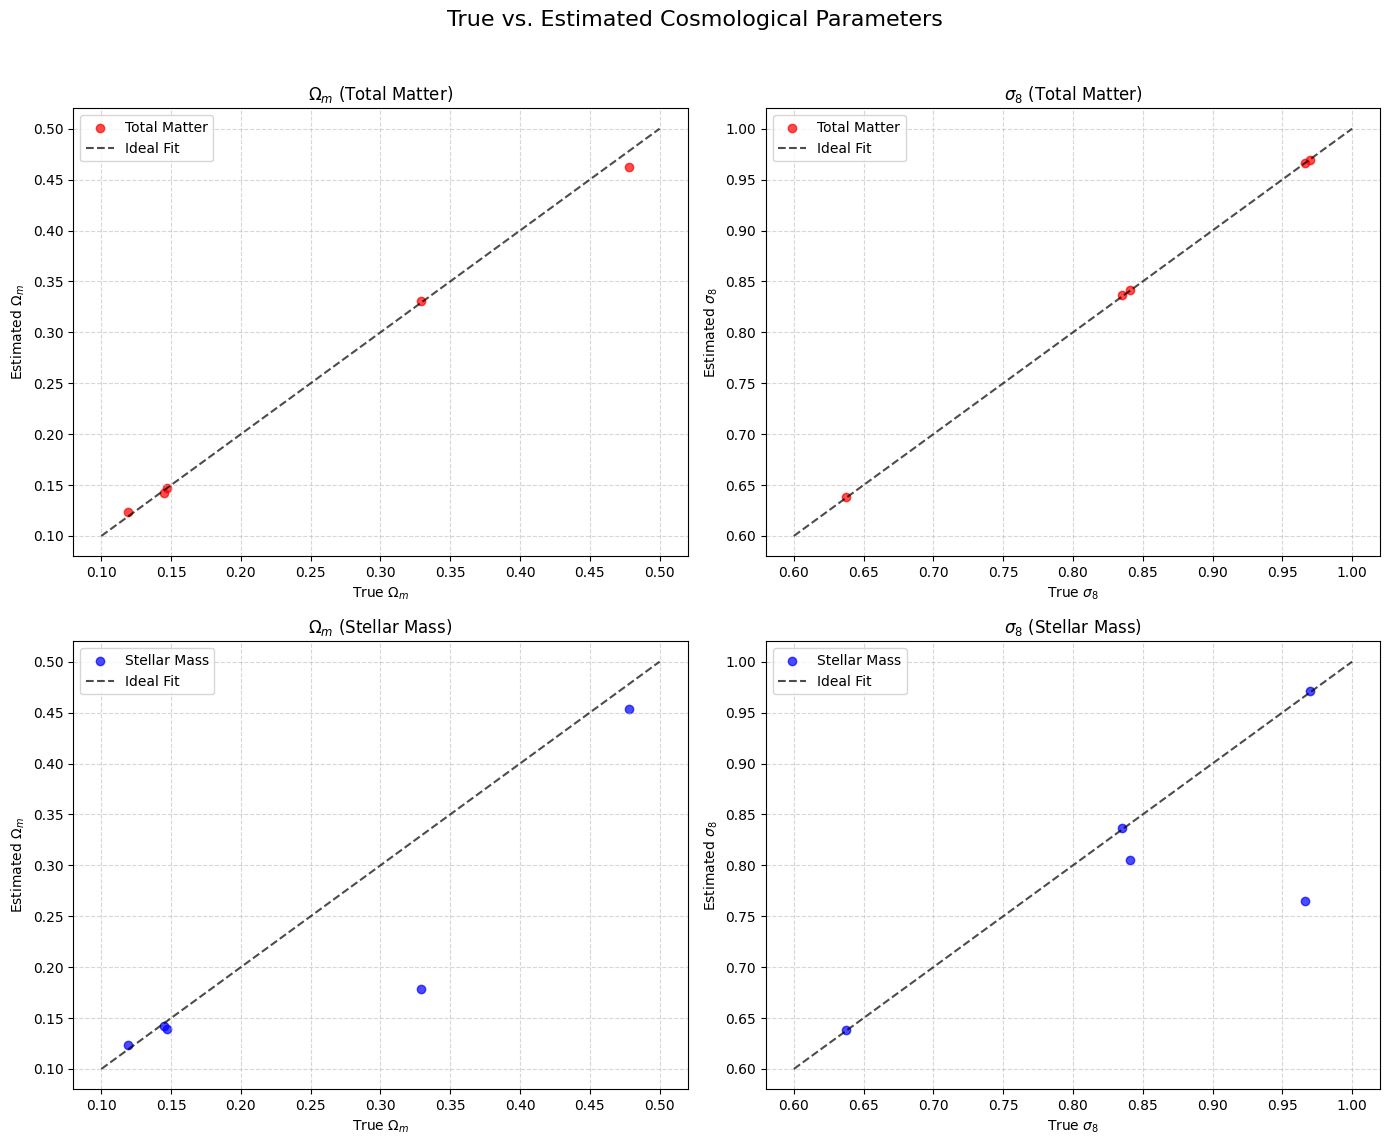

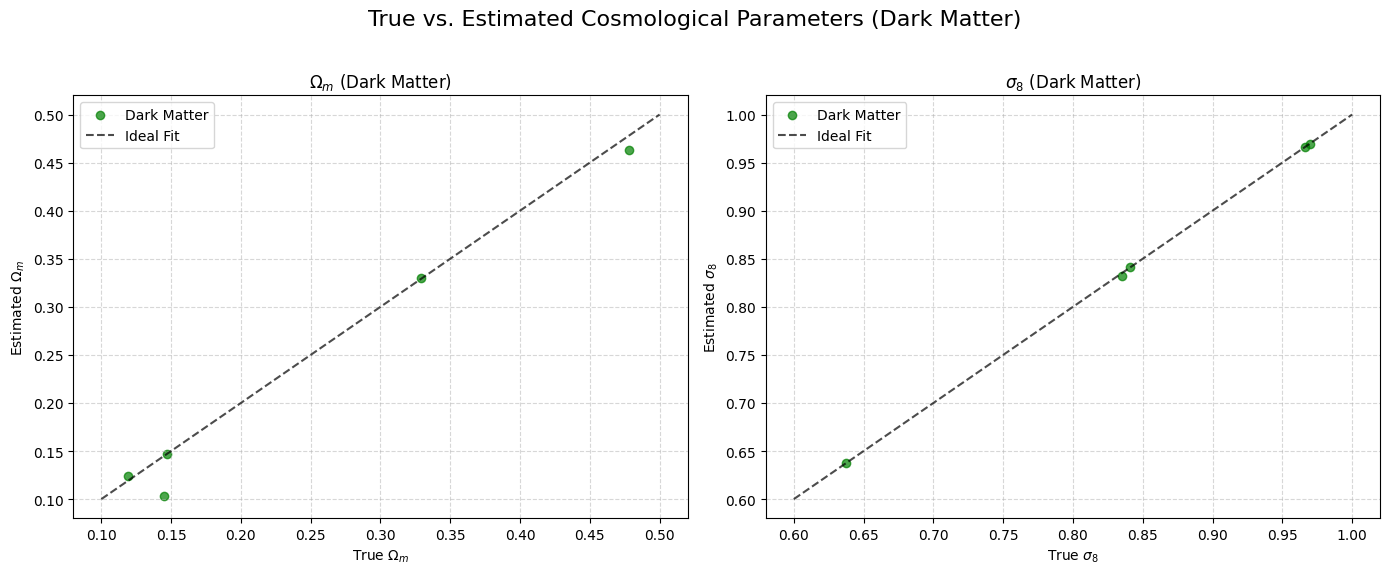

Generated scatter plots for true vs. estimated parameters.


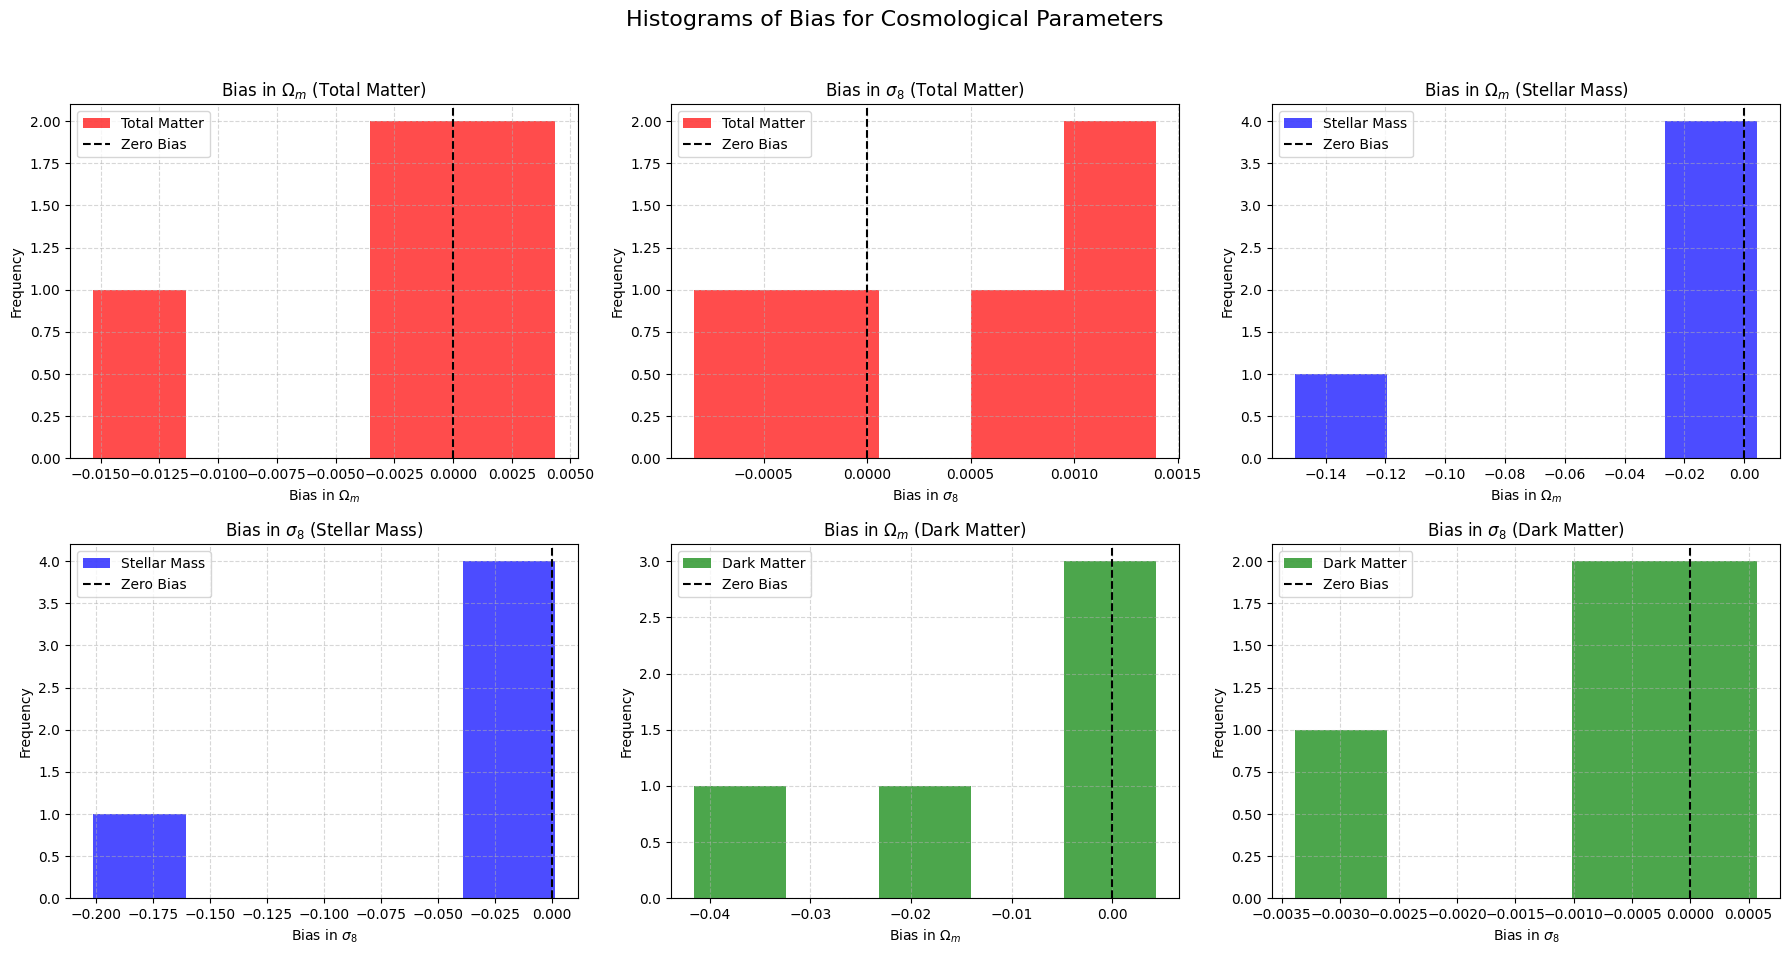

Generated histograms for parameter biases.


In [55]:
import matplotlib.pyplot as plt

# Prepare true parameters for plotting (converting lists of arrays to 2D numpy arrays)
true_params_mtot_np = np.array(all_true_params_total_matter)
true_params_mstar_np = np.array(all_true_params_mstar)
true_params_mcdm_np = np.array(all_true_params_mcdm)

# --- Scatter Plots: True vs. Estimated Parameters ---

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('True vs. Estimated Cosmological Parameters', fontsize=16)

# Omega_m: True vs. Estimated (Total Matter)
axes[0, 0].scatter(true_params_mtot_np[:, 0], estimated_omega_m_means_mtot, color='red', alpha=0.7, label='Total Matter')
axes[0, 0].plot([0.1, 0.5], [0.1, 0.5], 'k--', alpha=0.7, label='Ideal Fit')
axes[0, 0].set_xlabel(r'True $\Omega_m$')
axes[0, 0].set_ylabel(r'Estimated $\Omega_m$')
axes[0, 0].set_title(r'$\Omega_m$ (Total Matter)')
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.5)

# Sigma_8: True vs. Estimated (Total Matter)
axes[0, 1].scatter(true_params_mtot_np[:, 1], estimated_sigma_8_means_mtot, color='red', alpha=0.7, label='Total Matter')
axes[0, 1].plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.7, label='Ideal Fit')
axes[0, 1].set_xlabel(r'True $\sigma_8$')
axes[0, 1].set_ylabel(r'Estimated $\sigma_8$')
axes[0, 1].set_title(r'$\sigma_8$ (Total Matter)')
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Omega_m: True vs. Estimated (Stellar Mass)
axes[1, 0].scatter(true_params_mstar_np[:, 0], estimated_omega_m_means_mstar, color='blue', alpha=0.7, label='Stellar Mass')
axes[1, 0].plot([0.1, 0.5], [0.1, 0.5], 'k--', alpha=0.7, label='Ideal Fit')
axes[1, 0].set_xlabel(r'True $\Omega_m$')
axes[1, 0].set_ylabel(r'Estimated $\Omega_m$')
axes[1, 0].set_title(r'$\Omega_m$ (Stellar Mass)')
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Sigma_8: True vs. Estimated (Stellar Mass)
axes[1, 1].scatter(true_params_mstar_np[:, 1], estimated_sigma_8_means_mstar, color='blue', alpha=0.7, label='Stellar Mass')
axes[1, 1].plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.7, label='Ideal Fit')
axes[1, 1].set_xlabel(r'True $\sigma_8$')
axes[1, 1].set_ylabel(r'Estimated $\sigma_8$')
axes[1, 1].set_title(r'$\sigma_8$ (Stellar Mass)')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('True vs. Estimated Cosmological Parameters (Dark Matter)', fontsize=16)

# Omega_m: True vs. Estimated (Dark Matter)
axes[0].scatter(true_params_mcdm_np[:, 0], estimated_omega_m_means_mcdm, color='green', alpha=0.7, label='Dark Matter')
axes[0].plot([0.1, 0.5], [0.1, 0.5], 'k--', alpha=0.7, label='Ideal Fit')
axes[0].set_xlabel(r'True $\Omega_m$')
axes[0].set_ylabel(r'Estimated $\Omega_m$')
axes[0].set_title(r'$\Omega_m$ (Dark Matter)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Sigma_8: True vs. Estimated (Dark Matter)
axes[1].scatter(true_params_mcdm_np[:, 1], estimated_sigma_8_means_mcdm, color='green', alpha=0.7, label='Dark Matter')
axes[1].plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.7, label='Ideal Fit')
axes[1].set_xlabel(r'True $\sigma_8$')
axes[1].set_ylabel(r'Estimated $\sigma_8$')
axes[1].set_title(r'$\sigma_8$ (Dark Matter)')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("Generated scatter plots for true vs. estimated parameters.")

# --- Histograms of Biases ---

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Histograms of Bias for Cosmological Parameters', fontsize=16)

# Omega_m Bias (Total Matter)
axes[0, 0].hist(estimated_omega_m_biases_mtot, bins=5, color='red', alpha=0.7, label='Total Matter')
axes[0, 0].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[0, 0].set_xlabel(r'Bias in $\Omega_m$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(r'Bias in $\Omega_m$ (Total Matter)')
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.5)

# Sigma_8 Bias (Total Matter)
axes[0, 1].hist(estimated_sigma_8_biases_mtot, bins=5, color='red', alpha=0.7, label='Total Matter')
axes[0, 1].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[0, 1].set_xlabel(r'Bias in $\sigma_8$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(r'Bias in $\sigma_8$ (Total Matter)')
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Omega_m Bias (Stellar Mass)
axes[0, 2].hist(estimated_omega_m_biases_mstar, bins=5, color='blue', alpha=0.7, label='Stellar Mass')
axes[0, 2].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[0, 2].set_xlabel(r'Bias in $\Omega_m$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title(r'Bias in $\Omega_m$ (Stellar Mass)')
axes[0, 2].legend()
axes[0, 2].grid(True, linestyle='--', alpha=0.5)

# Sigma_8 Bias (Stellar Mass)
axes[1, 0].hist(estimated_sigma_8_biases_mstar, bins=5, color='blue', alpha=0.7, label='Stellar Mass')
axes[1, 0].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[1, 0].set_xlabel(r'Bias in $\sigma_8$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(r'Bias in $\sigma_8$ (Stellar Mass)')
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Omega_m Bias (Dark Matter)
axes[1, 1].hist(estimated_omega_m_biases_mcdm, bins=5, color='green', alpha=0.7, label='Dark Matter')
axes[1, 1].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[1, 1].set_xlabel(r'Bias in $\Omega_m$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(r'Bias in $\Omega_m$ (Dark Matter)')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.5)

# Sigma_8 Bias (Dark Matter)
axes[1, 2].hist(estimated_sigma_8_biases_mcdm, bins=5, color='green', alpha=0.7, label='Dark Matter')
axes[1, 2].axvline(0, color='k', linestyle='--', label='Zero Bias')
axes[1, 2].set_xlabel(r'Bias in $\sigma_8$')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title(r'Bias in $\sigma_8$ (Dark Matter)')
axes[1, 2].legend()
axes[1, 2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("Generated histograms for parameter biases.")

## Summary:

### Data Analysis Key Findings
*   **SIMBA Total Matter (Mtot) Tracer Performance:**
    *   `Omega_m`: Showed a low average bias of -0.0026 and a small average standard deviation of 0.0047, indicating robust and precise parameter recovery.
    *   `sigma_8`: Also exhibited a very low average bias of 0.0005 and a small average standard deviation of 0.0056, suggesting excellent recovery.
*   **SIMBA Dark Matter (Mcdm) Tracer Performance:**
    *   `Omega_m`: Had a relatively low average bias of -0.0103 and a small average standard deviation of 0.0042, performing comparably well to Total Matter.
    *   `sigma_8`: Showed a minimal average bias of -0.0007 and an average standard deviation of 0.0066, indicating good recovery.
*   **SIMBA Stellar Mass (Mstar) Tracer Performance:**
    *   `Omega_m`: Presented a significantly larger average bias of -0.0364 and a substantially higher average standard deviation of 0.0281 compared to the other tracers.
    *   `sigma_8`: Displayed the largest average bias of -0.0467 and the highest average standard deviation of 0.0433 among all tracers, suggesting less accurate and precise recovery.
*   **Overall Tracer Comparison:** The Stellar Mass tracer consistently yielded larger biases and standard deviations for both $\Omega_m$ and $\sigma_8$ than Total Matter and Dark Matter tracers, implying that Stellar Mass might be a less reliable tracer for cosmological parameter inference in this context.

### Insights or Next Steps
*   Further investigation is warranted into the reasons behind the larger biases and standard deviations observed with the Stellar Mass tracer. This could involve exploring the underlying astrophysical modeling, the simulation resolution, or the specific methods used to derive stellar mass in SIMBA. Ideally with more compute time/power, more tracers could be run for up to all 15000 maps of compatible data from the SIMBA CMD subset, or potentially other compatible datasets from other simulations like Astrid or IllustrisTNG could be run in a similar manner to compare and contrast models and the predictive power of their parameters post-analysis. Here we are only comparing SIMBA LH between N-Body Mtot, Mstar, and Mcdm, but there are 3 other sets (1P, CV, EX) in SIMBA alone, and many multiple fields for each of those sets, covering dimensions ranging from 1D to 3D. This lab analysis only covers a limited scope of the full breadth of data, but the methods show how this analysis could be generalized and combined with many different sets of data through the statistical methods employed in this class.
*   Given the superior performance of Total Matter and Dark Matter tracers, future cosmological analyses or survey designs should prioritize methodologies that allow for the accurate measurement or inference of these matter components to achieve more robust parameter recovery. This would involve integrating data from similar datasets that also cover more of the fields held in the CDM simulations, such as Gas Density, Gas Temperature, Magnetic Fields, etc... The analysis could also be done in multiple dimensions, probing power spectra and using similar methods to this lab on a 3D model utilizing modules and code designed to work on those volumes vs. areas of fields.


In [57]:
#HTML conversion script - first save .ipynb, upload to session storage, run on path, download html to submit.
%%shell
jupyter nbconvert --to html /content/LAB7_8AFfinal.ipynb

[NbConvertApp] Converting notebook /content/LAB7_8AFfinal.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 2103800 bytes to /content/LAB7_8AFfinal.html
